In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
import re
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

# k fold
from sklearn.model_selection import KFold

# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# linreg
from sklearn.linear_model import LinearRegression

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Also here it's paper algo!!! S(X) is estimated directly, like in the Chernozhukov's paper, unlike in other notebooks

# Difference to 6th DGP: b_0 and s_0 functions are switched!!!! Now b_0 is sparse, s_0 is not!!!

# Right now paper way of estimation seems better!!!! But also I have warnings in ElasticNet and some problems in LGBM (maybe the set of hyperparams is not good, so the optimal from this set is binding, so really optimal is not in my set!!!! Or in general something is wrong if going to the p>>n!!!!!!?????

# UPD: ACTUALLY THE STATEMENT ABOVE IS NOT SO OBVIOUS EVEN WHEN b_0 is not sparse and s_0 is sparse (6th DGP), but what if vice versa (7th DGP)!!!

# Here something strange happens with LGBM!!!!

# For baseline use LassoCV to choose lambda and also check papers (1 and 2) for UNBIASED 2-step procedure to find ATE (Since OLS cannot work in this case, as p >> n)!!!! If not CV, check theoretical value of Lambda in second paper (but need to work with factor loadings!!!)!!!!

# UPD: somehow, simple linear regression worked!!!!

# Should I use different data generating processes? I used similar, just generated more variables than observations, is it reasonable to try to make b_0 extremely complicated and not sparse, but heterogeneity function s_0 being sparse???!!! (Right now both b_0 and s_0 are sparse!!!). This may help to check whether my way of S(X) estimation is not far away from S(X) estimation in the paper!!!! But actually, I may just change the way of estimation everywhere!!!

# By the way, will it be Okay to deploy this code on public Github??? (If, for example, reference all the papers used?)

# Also ask about Master programmes!!!!

# Note: the whole notebook is automatized, so if check other DGPs, just copy the notebook, change ONE CELL with DGP and run the whole notebook (it's easy to do, run for 1.5-2 hours, depending on amount of data!!!)

# Also I can add depending on different datasplits, BLP metric is less stable, maybe this is the reason why it does not outperform. Also in some cases (no target tuning) higher BLP metric does not mean lower MAE, MSE!!!!
# Also Idea: combine BLP metric with GATES metric????? If relevant to do now, do now!!!!
# Or some other method of tuning???? (Not GridSearchCV???) Or target tuning algorithm (parts 'invented' by me) is not quite vaild!!!!???

# Some other idea!!!! Given tune_lambda_hat ML model for D = 1, optimize model for D = 0, based on the target!!!!! So it's double hyperparameter tuning, just some food for thought!!!! (Iteration proceedure)

# Also think about sample sizes, while tuning, maybe I can adjust it somehow, given that test size is larger if adding D = 0 data in target tuning!!!!???

# In target parameter tuning, validation set was lower than actual B sample by three times!!!! And validation set is almost equal to the training sets for ML estimations (I mean size of training sets during hypertuning)!!! (equal if propensity score = 0.5 on average)

# Also do proper check of the work, I am a little bit confused by the metrics, during tuning!!!

## Conclusion: even if not outperform MSE tuning, target tuning may bring alternative hyperparameters which may create more robust estimation, I CAN CHECK THAT?????

In [2]:
# importing main function from .py file with functions!!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_PAPER_ALGO

# import lambda hat function for tuning from .py file with functions!!!
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import lambda_hat_tuning_CV

# importing other functions
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_compare_two_models_PAPER_ALGO
from functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper import term_paper_main_func_easy_baseline

## DGP which was not perfectly estimated by default ML estimations

In [3]:
np.random.seed(100)
# empty df
df = pd.DataFrame()
# NUMBER OF OBSERVATIONS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
obs = 270
# explanatory variables: X
df['x1'] = np.random.uniform(-1, 3, obs)
x2 = np.random.uniform(-6, 2, obs)
x3 = np.random.uniform(8, 14, obs)
k0, k1 = np.random.multivariate_normal([3, 5], [[1, 0.8], [0.8, 1]], obs).T
df['x4'] = k0 * 3
df['x5'] = k1 * 7
k2, k3, k4 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, 0.4, 0.5], 
                                                                            [0.4, 1, 0.9], 
                                                                            [0.5, 0.9, 1]]), obs).T
df['x6'] = k2 * 6
x7 = k2 * k3 - k4
df['x8'] = np.sin(k4)
k5, k6, k7 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                            [-0.4, 1, 0.9], 
                                                                            [-0.5, 0.9, 1]]), obs).T
df['x9'] = k5
df['x10'] = k6
df['x11'] = k7
x12 = np.random.uniform(-10, 20, obs)
df['x13'], k8, k9 = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.4, -0.5], 
                                                                                                    [-0.4, 1, 0.9], 
                                                                                                    [-0.5, 0.9, 1]]), obs).T

df['x14'] = np.random.uniform(-6, 2, obs)
df['x15'] = np.random.uniform(8, 14, obs)
df['x16'], df['x17'], df['x18'] = np.random.multivariate_normal(np.array([-1, 0.3, 1.7]), np.array([[1, -0.1, -0.5], 
                                                                                                    [-0.1, 1, 0], 
                                                                                                    [-0.5, 0, 1]]), obs).T
# NEW PART!!!!!!
for k in range (5, 255):
    name1 = 'x' + str(k * 5)
    name2 = 'x' + str(k * 5 + 1)
    name3 = 'x' + str(k * 5 + 2)
    name4 = 'x' + str(k * 5 + 3)
    name5 = 'x' + str(k * 5 + 4)
    matr = np.random.normal(0.5, 1.5, 25).reshape((5, 5))
    cov_matr = matr @ matr.T
    a, b, c, d, e = np.random.multivariate_normal(np.array([-1, 0.3, 1.7, 0, 0]), cov_matr, obs).T
    df[name1] = a
    df[name2] = b
    df[name3] = c
    df[name4] = d
    df[name5] = e

# NEW: MAKING b_0 NOT SPARSE!!!!
weights_list = list(np.random.uniform(-0.05, 0.25, len(x_cols[::3])))
linear_factor = np.zeros(df.shape[0])

for num, col in enumerate(x_cols[::3]):
    linear_factor = linear_factor + df[col] * weights_list[num]
        
eps = np.random.normal(0, 1024, obs)
eps1 = np.random.normal(0, 1024, obs)
# b(X) = Y(0)
df['b_0'] = 4 + 6*df.x1 + 8*x2 - 9*df.x1*x2 + 3 * np.log(x3) -\
        np.maximum(df.x4, 0.3) **(1/3) * x3 + np.exp(x7 / 5) + np.maximum(0, df.x8) +\
        0.5 * (x7 - df.x8) * np.minimum(df.x6, -1) + np.minimum(df['x10'] - df['x11'] * (df['x9'] + x7), x12) +\
        linear_factor + eps
# propensity score: p(D = 1 | X), bounded from 0 and 1
df['p'] = (8 + df.x1 + x2 + x3 * 0.5) / 32
# s(X) = Y(1) - Y(0)
df['s_0(X)'] = 3 * df.x1 + x2 + df.x1 * x2 + df.x25 ** 2 * df.x27 * 3 + 7 * df.x34 * x7 + eps1

# whether the treatment was assigned (D), given propensity score
df['D'] = np.random.binomial(1, df.p)
# CREATION OF Y:
df['y'] = df.b_0 + df['s_0(X)'] * df.D

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name1] = a
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name2] = b
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name3] = c
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name4] = d
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name5] = e
C:\Users\052\AppData\Local\Temp\ipykernel_11292\2755434777.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [ ]:
### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)

In [4]:
df.head()

,x1,x4,x5,x6,x8,x9,x10,x11,x13,x14,...,x1270,x1271,x1272,x1273,x1274,b_0,p,s_0(X),D,y
0,1.173620,15.783567,48.779728,-5.685639,0.745728,0.395395,-0.325419,1.224755,-2.279018,-4.619105,...,-1.353034,-1.761774,3.341376,-2.918566,-0.932758,-155.808723,0.488986,-1261.569471,0,-155.808723
1,0.113478,4.438045,24.019415,-2.927082,0.779136,-1.448864,1.332845,2.441188,-1.509696,-3.180923,...,-3.002687,0.259409,0.482626,-3.024970,-2.644444,-142.123760,0.398772,-1240.305162,0,-142.123760
2,0.698070,13.708881,42.534189,-4.178835,0.888943,-0.679539,1.991485,3.274681,-0.963150,-2.636642,...,-5.358939,0.862657,-2.614172,-0.533875,2.576377,-2175.847329,0.280332,915.826762,0,-2175.847329
3,2.379105,6.563017,31.407383,-1.870586,-0.033742,0.277188,-0.326752,1.426350,-0.814473,0.843613,...,-2.566396,-0.941067,2.499002,-3.106721,-0.994086,-1204.880766,0.483574,-656.663841,1,-1861.544608
4,-0.981125,9.600102,37.218350,-4.917191,0.852696,-0.758194,-0.838417,0.582920,-1.408251,-0.069436,...,-1.453032,-6.673956,1.309626,-5.791325,1.527457,-1513.804861,0.399640,-224.188993,1,-1737.993854


### Importing models

In [5]:
# rf
from sklearn.ensemble import RandomForestRegressor

# Elsstic net
from sklearn.linear_model import ElasticNet

# LightGBM
from lightgbm import LGBMRegressor

# 1) Tuning all models by minimisation of MSE of both B(X) and E(Y|X,D=1) modelling

In [6]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)
        
X_train0 = df_A[df_A['D'] == 0][x_cols]
y_train0 = df_A[df_A['D'] == 0]['y']
scaler0 = MinMaxScaler()
scaler0.fit(X_train0)
X_train0 = scaler0.transform(X_train0)

X_train1 = df_A[df_A['D'] == 1][x_cols]
y_train1 = df_A[df_A['D'] == 1]['y']
scaler1 = MinMaxScaler()
scaler1.fit(X_train1)
X_train1 = scaler1.transform(X_train1)

### Setting default models to tune

In [7]:
# rf
rf0 = RandomForestRegressor()
rf1 = RandomForestRegressor()

# Elastic net
elast0 = ElasticNet()
elast1 = ElasticNet()

# LightGBM
lgbm0 = LGBMRegressor()
lgbm1 = LGBMRegressor()

### a) Tuning rf

In [8]:
params_rf0 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

params_rf1 = {'n_estimators': [250],
            'max_depth':  [None, 7, 10, 12],
            'min_samples_leaf': [1, 10, 50, 100], 
            'max_features': ['auto', 'sqrt', 'log2', None],
             'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1]}

In [9]:
grid_rf0 = GridSearchCV(estimator = rf0, 
                        param_grid = params_rf0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_rf1 = GridSearchCV(estimator = rf1, 
                        param_grid = params_rf1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [10]:
grid_rf0.fit(X_train0, y_train0)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [11]:
grid_rf1.fit(X_train1, y_train1)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 7, 10, 12],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_leaf': [1, 10, 50, 100],
                         'n_estimators': [250]},
             scoring='neg_mean_squared_error', verbose=20)

In [12]:
grid_rf0.best_estimator_

RandomForestRegressor(max_depth=7, max_features='sqrt',
                      min_impurity_decrease=0.1, n_estimators=250)

In [13]:
grid_rf1.best_estimator_

RandomForestRegressor(max_depth=10, max_features='log2',
                      min_impurity_decrease=0.001, n_estimators=250)

In [14]:
rf0_tune_MSE = grid_rf0.best_estimator_
rf1_tune_MSE = grid_rf1.best_estimator_

### b) Tuning Elastic Net

In [15]:
elast0.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [16]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [17]:
params_elast0 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

params_elast1 = {'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
               'l1_ratio': np.linspace(0, 1, 11)}

In [18]:
grid_elast0 = GridSearchCV(estimator = elast0, 
                        param_grid = params_elast0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_elast1 = GridSearchCV(estimator = elast1, 
                        param_grid = params_elast1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [19]:
grid_elast0.fit(X_train0, y_train0)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [20]:
grid_elast1.fit(X_train1, y_train1)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.524e+04, tolerance: 7.345e+03
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=3, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=20)

In [21]:
grid_elast0.best_estimator_

ElasticNet(alpha=100, l1_ratio=1.0)

In [22]:
grid_elast1.best_estimator_

ElasticNet(alpha=0.001, l1_ratio=0.4)

In [23]:
elast0_tune_MSE = grid_elast0.best_estimator_
elast1_tune_MSE = grid_elast1.best_estimator_

### c) Tuning Lgbm: 
# parameters are quite different from those optimized by Chernozhukov in the paper!!!!

In [24]:
lgbm0.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [25]:
# # What about adding reg_alpha and reg_lambda?????
params_lgbm0 = {'colsample_bytree': [0.02, 0.05, 0.07, 0.1], 
                 'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.07], 
                 'num_leaves': [2, 3, 5], 
                 'min_split_gain': [0, 0.0001], 
                 'min_child_weight': [0, 0.0001], 
                 'n_estimators': [2, 3], 
                 'silent': [False]}

params_lgbm1 = {'colsample_bytree': [0.02, 0.05, 0.07, 0.1], 
                 'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05, 0.07], 
                 'num_leaves': [2, 3, 5], 
                 'min_split_gain': [0, 0.0001], 
                 'min_child_weight': [0, 0.0001], 
                 'n_estimators': [2, 3], 
                 'silent': [False]}

In [26]:
grid_lgbm0 = GridSearchCV(estimator = lgbm0, 
                        param_grid = params_lgbm0,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

grid_lgbm1 = GridSearchCV(estimator = lgbm1, 
                        param_grid = params_lgbm1,
                        cv = 3,
                        scoring = 'neg_mean_squared_error', 
                        n_jobs = -1, 
                        verbose = 20)

In [27]:
grid_lgbm0.fit(X_train0, y_train0)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -101.676823


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.02, 0.05, 0.07, 0.1],
                         'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05,
                                           0.07],
                         'min_child_weight': [0, 0.0001],
                         'min_split_gain': [0, 0.0001], 'n_estimators': [2, 3],
                         'num_leaves': [2, 3, 5], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [28]:
grid_lgbm1.fit(X_train1, y_train1)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score -337.308020


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.02, 0.05, 0.07, 0.1],
                         'learning_rate': [0.003, 0.005, 0.01, 0.03, 0.05,
                                           0.07],
                         'min_child_weight': [0, 0.0001],
                         'min_split_gain': [0, 0.0001], 'n_estimators': [2, 3],
                         'num_leaves': [2, 3, 5], 'silent': [False]},
             scoring='neg_mean_squared_error', verbose=20)

In [29]:
grid_lgbm0.best_estimator_

LGBMRegressor(colsample_bytree=0.02, learning_rate=0.07, min_child_weight=0,
              min_split_gain=0, n_estimators=3, num_leaves=3, silent=False)

In [30]:
grid_lgbm1.best_estimator_

LGBMRegressor(colsample_bytree=0.02, learning_rate=0.003, min_child_weight=0,
              min_split_gain=0, n_estimators=2, num_leaves=2, silent=False)

In [31]:
lgbm0_tune_MSE = grid_lgbm0.best_estimator_
lgbm1_tune_MSE = grid_lgbm1.best_estimator_

# 2) Set of models, tuned by MSE (B(X)), target BLP metric (S(X)) + How they perform compared to models tuned by MSE only and to default non-tuned models!!!

In [32]:
### Split the data onto 2 parts
obs = df.shape[0]
ind_A = random.sample(range(int(obs)), int(obs / 2))
ind_B = list(set(range(int(obs))).difference(set(ind_A)))
df_A = df.iloc[ind_A, :].copy()
df_B = df.iloc[ind_B, :].copy()

### Automatic search for the covariates columns!!!
x_cols = []
for i in df.columns:
    regexp = re.compile(r'^x\d+')
    if regexp.search(i):
        x_cols.append(i)

In [33]:
df_A_0 = df_A[df_A['D'] == 0].copy()
df_A_1 = df_A[df_A['D'] == 1].copy()

### a) Tuning rf: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [34]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# rf0_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 0, 
#                                      max_features = None, 
#                                      max_depth = 12)

# rf1_tune_MSE = RandomForestRegressor(n_estimators = 250, 
#                                      min_impurity_decrease = 1)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [35]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
rf0_tune_MSE1 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE2 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

rf0_tune_MSE3 = RandomForestRegressor(
                        n_estimators = rf0_tune_MSE.get_params()['n_estimators'], 
                        min_impurity_decrease = rf0_tune_MSE.get_params()['min_impurity_decrease'], 
                        max_features = rf0_tune_MSE.get_params()['max_features'], 
                        max_depth = rf0_tune_MSE.get_params()['max_depth'],
                        min_samples_leaf = rf0_tune_MSE.get_params()['min_samples_leaf']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [36]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [rf0_tune_MSE1, rf0_tune_MSE2, rf0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

## Actual target tuning!!!! Kinda BackBone approach!!!

In [37]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
j = 0

for max_depth in tqdm_notebook([None, 7, 10, 12]):
    for min_samples_leaf in tqdm([1, 10, 50, 100]):
        for max_features in ['auto', 'sqrt', 'log2', None]:
            for min_impurity_decrease in [0, 0.001, 0.01, 0.1, 1]:
                
                rf_sup = RandomForestRegressor(n_estimators = 250,
                                               max_depth = max_depth, 
                                               min_samples_leaf = min_samples_leaf, 
                                               max_features = max_features, 
                                               min_impurity_decrease = min_impurity_decrease)

                cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                if cur_lambda_hat > best_lambda_hat: 
                    j += 1
                    best_lambda_hat = cur_lambda_hat
                    best_params['min_samples_leaf'] = min_samples_leaf
                    best_params['max_depth'] = max_depth
                    best_params['max_features'] = max_features
                    best_params['min_impurity_decrease'] = min_impurity_decrease
                    if j % 2 == 0:
                        print(best_lambda_hat)
                        print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_11292\1730115383.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for max_depth in tqdm_notebook([None, 7, 10, 12]):


  0%|          | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

431332.33443699125
{'min_samples_leaf': 1, 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0.001}



100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:52<00:00, 43.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:55<00:00, 43.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:55<00:00, 43.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:56<00:00, 44.21s/it]


In [38]:
best_params, best_lambda_hat

({'min_samples_leaf': 1,
  'max_depth': None,
  'max_features': 'auto',
  'min_impurity_decrease': 0.001},
 431332.33443699125)

In [39]:
rf1_tune_Lambda_hat = RandomForestRegressor(n_estimators = 250, 
                                   max_depth = best_params['max_depth'], 
                                   min_samples_leaf = best_params['min_samples_leaf'], 
                                   max_features = best_params['max_features'], 
                                   min_impurity_decrease = best_params['min_impurity_decrease'])

### General (non-pairwise) comparison of 3 rf specifications: target tuned, MSE tuned, default!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:10<00:00,  4.91s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,42377.576010,219625.709540,795.534520,1.019659e+06,7451.858920,-0.176590,0.012470
std,68176.259586,142321.893779,46.100291,1.072974e+05,9628.452708,1.038594,0.458774
min,3.092000,7616.799000,706.009000,8.080718e+05,0.344000,-2.995000,-0.908000
25%,2784.045250,98425.262500,763.148000,9.500400e+05,457.624750,-0.926500,-0.314250
50%,15510.068500,208933.641000,792.452000,1.010442e+06,3508.030500,-0.177500,0.011000
75%,65412.435250,298545.077000,830.905500,1.080918e+06,11533.903250,0.367500,0.278750
max,405486.172000,791025.287000,931.024000,1.317792e+06,42821.096000,2.878000,1.158000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,51.632,-1428.141,1445.374,-1289.417,-1529.742,-1062.570
G2,99.795,-1346.412,1541.302,-436.014,-540.148,-337.069
G3,182.974,-1248.384,1544.885,115.923,51.375,176.950
G4,96.211,-1338.443,1464.665,562.119,492.279,635.571
G5,-54.707,-1500.933,1386.754,1431.535,1151.442,1704.945


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,51.632,-1428.141,1445.374,-1289.417,-1529.742,-1062.570
x1,1.005,0.377,1.653,1.118,0.570,1.657
x4,9.098,7.564,10.613,8.902,7.188,10.630
x5,34.947,31.203,38.532,35.299,31.794,38.735
x6,-6.631,-9.702,-3.438,-7.808,-11.231,-4.237
...,...,...,...,...,...,...
x1270,-1.254,-2.789,0.382,-1.822,-3.383,-0.337
x1271,0.459,-0.943,1.867,0.098,-1.337,1.579
x1272,1.800,0.115,3.513,1.247,-0.612,3.007
x1273,0.289,-1.706,2.280,-0.697,-2.570,1.166


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-54.707,-1500.933,1386.754,1431.535,1151.442,1704.945
x1,1.027,0.416,1.630,1.039,0.415,1.676
x4,9.145,7.582,10.659,9.453,7.611,11.335
x5,35.048,31.053,38.807,36.080,31.640,40.489
x6,-6.306,-9.427,-3.122,-5.733,-8.936,-2.498
...,...,...,...,...,...,...
x1270,-1.223,-2.768,0.402,-0.648,-2.057,0.764
x1271,0.644,-0.663,2.055,0.825,-0.571,2.250
x1272,1.893,0.341,3.434,1.489,-0.146,3.131
x1273,0.212,-1.782,2.286,0.451,-1.635,2.479


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-29.974,-2078.643,1979.612,2719.884,2347.849,3085.566
x1,0.030,-0.857,0.926,-0.053,-0.877,0.786
x4,-0.003,-2.174,2.250,0.540,-1.937,3.028
x5,0.011,-5.164,5.294,0.878,-4.775,6.531
x6,0.148,-4.423,4.858,2.219,-2.597,6.878
...,...,...,...,...,...,...
x1270,0.002,-2.244,2.289,1.200,-0.879,3.316
x1271,0.242,-1.750,2.205,0.697,-1.254,2.683
x1272,0.095,-2.210,2.394,0.234,-2.154,2.627
x1273,-0.048,-2.964,2.852,1.019,-1.665,3.949


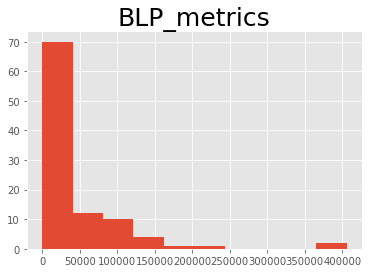

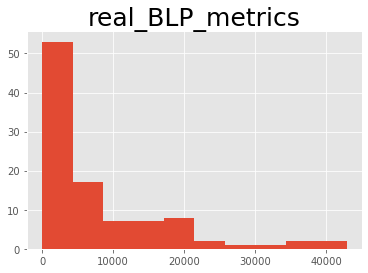

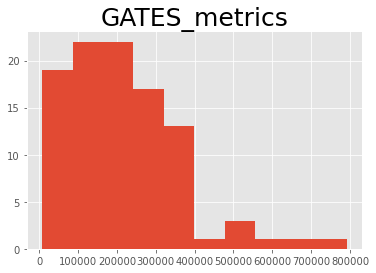

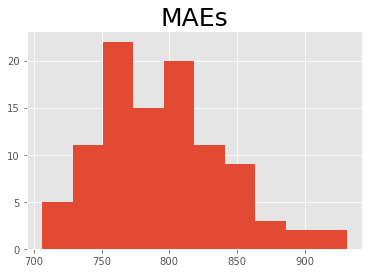

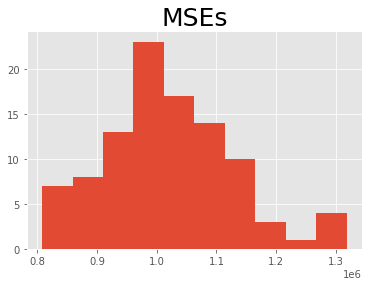

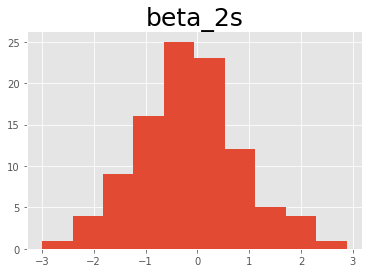

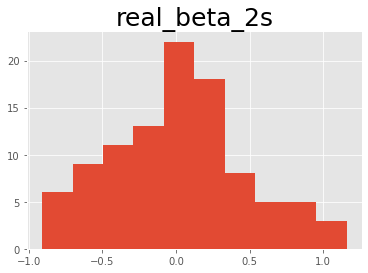

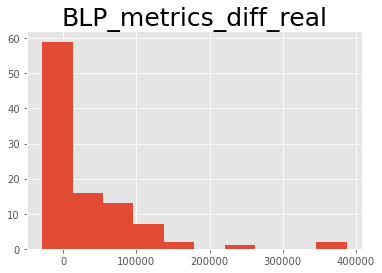

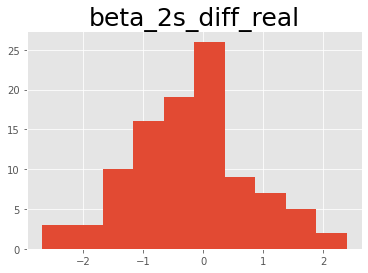

In [69]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,100.00000
mean,53451.715170,2.486365e+05,784.096350,9.823926e+05,7226.259250,-0.254220,0.00747
std,62931.181467,1.689936e+05,40.189149,9.119788e+04,11153.522621,2.193987,0.82887
min,29.635000,1.593214e+04,652.975000,7.449811e+05,0.022000,-5.415000,-1.98300
25%,8501.957250,1.408001e+05,760.328250,9.390708e+05,593.804750,-1.965750,-0.54500
50%,31353.756000,2.043144e+05,782.773000,9.810662e+05,4053.306000,-0.298500,-0.02100
75%,85148.415750,3.038690e+05,814.367250,1.036757e+06,9937.175250,1.392000,0.61925
max,319314.064000,1.003574e+06,900.637000,1.297548e+06,85565.834000,4.295000,2.82500


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,25.901,-1466.989,1493.453,-1279.690,-1509.578,-1052.704
G2,161.814,-1339.520,1578.952,-424.284,-524.261,-323.881
G3,218.874,-1256.041,1712.912,130.259,62.175,190.907
G4,77.807,-1398.869,1485.702,571.041,503.016,641.585
G5,84.340,-1391.330,1465.931,1437.965,1158.079,1720.838


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,25.901,-1466.989,1493.453,-1279.690,-1509.578,-1052.704
x1,0.998,0.350,1.631,1.098,0.569,1.655
x4,9.225,7.718,10.757,8.865,7.208,10.544
x5,35.224,31.517,38.847,35.343,31.783,38.894
x6,-6.481,-9.718,-3.153,-7.800,-11.161,-4.282
...,...,...,...,...,...,...
x1270,-1.198,-2.757,0.388,-1.775,-3.350,-0.237
x1271,0.529,-0.936,1.985,0.079,-1.335,1.536
x1272,1.828,0.233,3.544,1.210,-0.587,2.970
x1273,0.155,-1.836,2.131,-0.761,-2.705,1.131


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,84.340,-1391.330,1465.931,1437.965,1158.079,1720.838
x1,1.008,0.357,1.631,1.009,0.362,1.660
x4,8.983,7.471,10.526,9.423,7.621,11.227
x5,34.618,31.026,38.199,35.763,31.321,40.294
x6,-6.018,-9.085,-2.841,-5.308,-8.553,-2.215
...,...,...,...,...,...,...
x1270,-0.998,-2.509,0.565,-0.600,-2.001,0.792
x1271,0.595,-0.797,1.984,0.808,-0.548,2.236
x1272,1.943,0.404,3.518,1.640,-0.049,3.221
x1273,0.354,-1.653,2.267,0.420,-1.697,2.618


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-14.265,-2009.191,2034.755,2716.877,2356.677,3077.277
x1,0.011,-0.874,0.892,-0.060,-0.911,0.776
x4,-0.225,-2.424,1.920,0.589,-1.868,3.078
x5,-0.529,-5.583,4.645,0.592,-4.988,6.419
x6,0.483,-4.158,5.117,2.321,-2.303,7.044
...,...,...,...,...,...,...
x1270,0.240,-1.975,2.391,1.218,-0.842,3.298
x1271,0.092,-1.999,2.115,0.763,-1.201,2.769
x1272,0.045,-2.223,2.325,0.353,-2.016,2.792
x1273,0.308,-2.641,3.048,1.236,-1.662,4.051


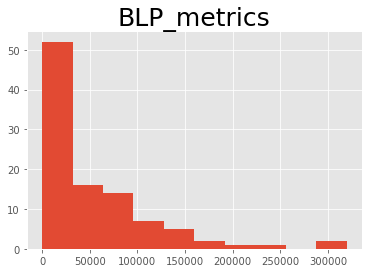

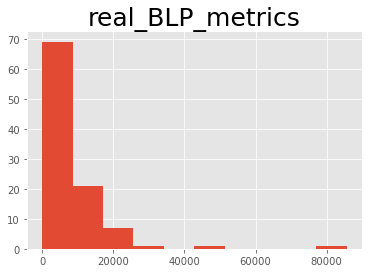

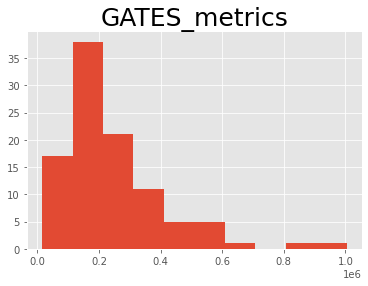

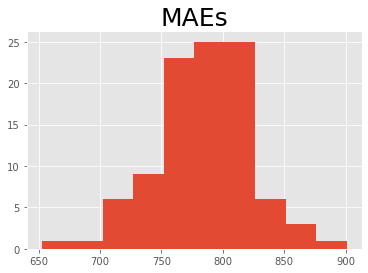

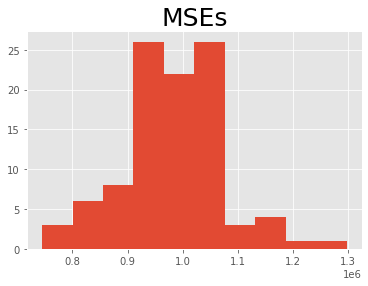

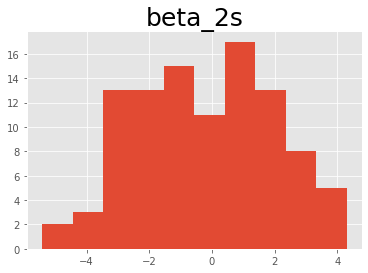

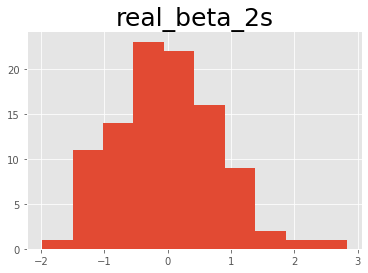

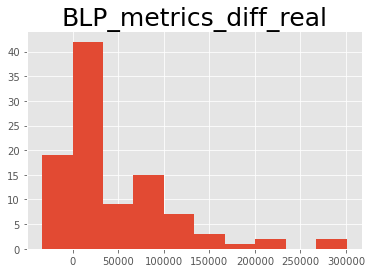

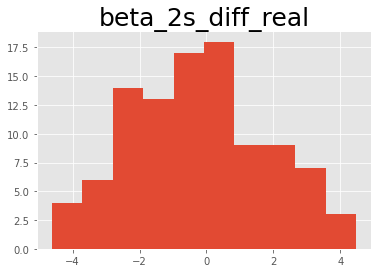

In [41]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = rf1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.37s/it]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.00000,100.000000,100.000000
mean,44561.297340,251004.269310,810.007530,1.048638e+06,5564.30312,0.145610,-0.048410
std,54472.669699,147151.990535,49.610873,1.242064e+05,8873.11961,0.952119,0.323999
min,62.177000,32853.121000,697.576000,7.947303e+05,0.08000,-1.701000,-0.839000
25%,6001.484500,128777.871500,782.494250,9.822824e+05,489.74875,-0.539500,-0.262250
50%,22822.708500,236423.572500,803.738000,1.032497e+06,1733.63850,0.151000,-0.031000
75%,63605.809250,350738.486500,834.555250,1.106304e+06,5952.14550,0.756500,0.140000
max,239003.188000,730137.916000,1074.703000,1.763876e+06,53818.78000,2.963000,0.780000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,103.383,-1351.546,1554.451,-1288.040,-1527.944,-1046.271
G2,20.596,-1402.585,1414.355,-431.571,-535.170,-332.656
G3,151.323,-1310.138,1547.946,118.419,59.797,185.956
G4,39.714,-1340.261,1474.542,568.593,496.315,648.932
G5,28.536,-1305.473,1509.316,1447.971,1179.257,1729.172


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,103.383,-1351.546,1554.451,-1288.040,-1527.944,-1046.271
x1,0.991,0.385,1.628,1.075,0.538,1.628
x4,9.137,7.540,10.725,8.773,7.099,10.453
x5,34.953,31.155,38.741,35.107,31.596,38.565
x6,-6.469,-9.582,-3.199,-7.790,-11.265,-4.196
...,...,...,...,...,...,...
x1270,-1.197,-2.784,0.414,-1.837,-3.401,-0.332
x1271,0.471,-1.025,1.797,0.167,-1.321,1.617
x1272,1.712,-0.018,3.443,1.264,-0.506,3.026
x1273,0.225,-1.777,2.195,-0.649,-2.589,1.207


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,28.536,-1305.473,1509.316,1447.971,1179.257,1729.172
x1,1.020,0.404,1.663,1.033,0.392,1.682
x4,8.981,7.501,10.427,9.463,7.606,11.259
x5,34.580,30.813,38.253,35.954,31.543,40.393
x6,-6.334,-9.528,-3.116,-5.654,-8.962,-2.420
...,...,...,...,...,...,...
x1270,-1.232,-2.899,0.433,-0.631,-2.088,0.740
x1271,0.573,-0.825,2.011,0.825,-0.591,2.267
x1272,1.828,0.292,3.267,1.486,-0.201,3.105
x1273,0.221,-1.804,2.340,0.478,-1.660,2.570


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,74.416,-1987.412,2088.490,2732.836,2366.828,3094.733
x1,0.005,-0.900,0.910,-0.035,-0.891,0.810
x4,-0.116,-2.280,2.079,0.744,-1.796,3.135
x5,-0.491,-5.796,4.882,0.979,-4.824,6.586
x6,-0.102,-4.622,4.550,1.933,-2.706,6.746
...,...,...,...,...,...,...
x1270,-0.012,-2.299,2.305,1.172,-0.872,3.297
x1271,0.135,-1.880,2.149,0.600,-1.329,2.692
x1272,0.087,-2.221,2.361,0.166,-2.279,2.558
x1273,0.111,-2.891,3.094,1.117,-1.769,4.032


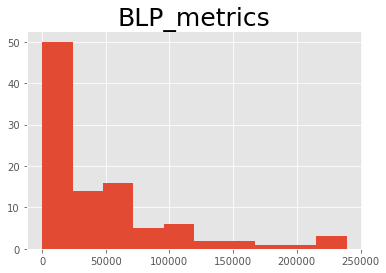

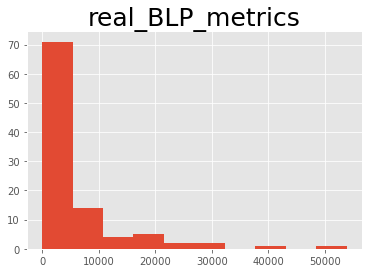

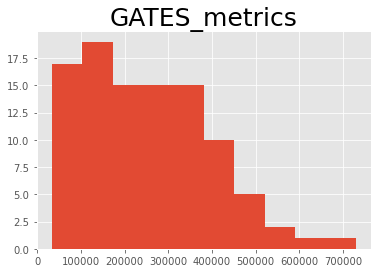

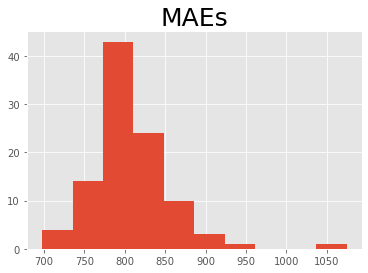

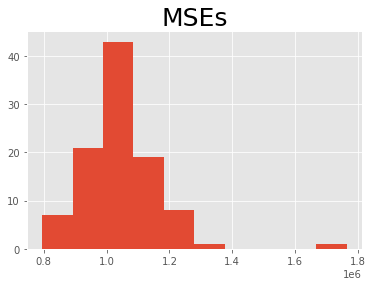

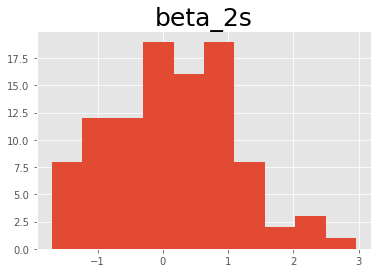

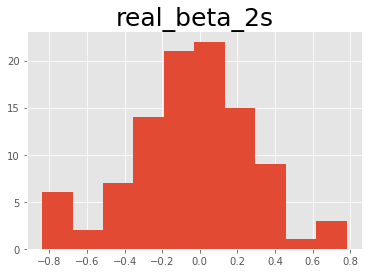

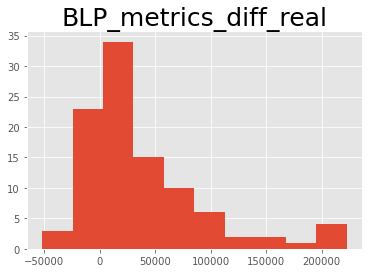

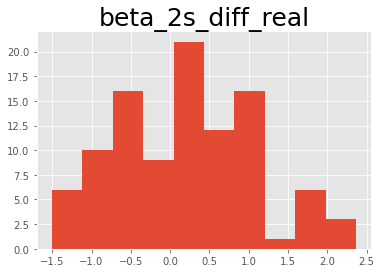

In [42]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = rf0_tune_MSE, model1 = RandomForestRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### b) Tuning Elastic Net: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [43]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# elast0_tune_MSE = ElasticNet(alpha=0.1, 
#                           l1_ratio=1.0)

# elast1_tune_MSE = ElasticNet(alpha = 0.1, 
#                             l1_ratio = 1.0)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [44]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
elast0_tune_MSE1 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE2 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

elast0_tune_MSE3 = ElasticNet(alpha = elast0_tune_MSE.get_params()['alpha'], 
                          l1_ratio = elast0_tune_MSE.get_params()['l1_ratio']
)

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [45]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [elast0_tune_MSE1, elast0_tune_MSE2, elast0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

In [46]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    for l1_ratio in tqdm(np.linspace(0, 1, 11)):
        
        rf_sup = ElasticNet(alpha = alpha,
                                l1_ratio = l1_ratio)

        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                x_cols = x_cols, list_models0 = list_models0, 
                                                OOF0_samples = OOF0_samples, scalers0 = scalers0)
        if cur_lambda_hat > best_lambda_hat: 
            i += 1
            best_lambda_hat = cur_lambda_hat
            best_params['alpha'] = alpha
            best_params['l1_ratio'] = l1_ratio
            if i % 2 == 0:
                print(best_lambda_hat)
                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_11292\2629798658.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm_notebook([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]):


  0%|          | 0/9 [00:00<?, ?it/s]


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-package

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(

 45%|█████████████████████████████████████▋                                             | 5/11 [00:01<00:01,  4.20it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_

D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(

 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:02<00:00,  4.35it/s]D:\Documents\VSHE\3_year\Курсовая\Coding\functions_realisation_of_Chernozhukov_paper_with_only_ideas_needed_for_my_paper.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model1.fit(scaler1.transform(X_train1), y_train1)
C:\Users\052\anaconda3\lib\site-package

222336.51425180098
{'alpha': 0.0001, 'l1_ratio': 0.0}


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e+04, tolerance: 6.687e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.114e+04, tolerance: 5.8

267357.5589371458
{'alpha': 0.0001, 'l1_ratio': 0.2}


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+04, tolerance: 6.687e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+04, tolerance: 5.8

289578.6490980214
{'alpha': 0.0001, 'l1_ratio': 0.4}


C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.962e+03, tolerance: 6.687e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.816e+03, tolerance: 5.8

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.606e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e+04, tolerance: 5.858e+03
  model = cd_fast.enet_coordinate_descent(

 27%|██████████████████████▋                                                            | 3/11 [00:02<00:05,  1.39it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+04, tolerance: 5.858e+03
  model = cd_fast.enet_coordinate_descent(

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.55it/s]

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_mod

 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:04<00:03,  1.43it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.701e+04, tolerance: 6.687e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.095e+04, tolerance: 6.789e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of it

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  3.69it/s]

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+07, tolerance: 6.687e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

In [47]:
best_params, best_lambda_hat

({'alpha': 0.001, 'l1_ratio': 0.5}, 333200.0520729411)

In [48]:
elast1_tune_Lambda_hat = ElasticNet(alpha = best_params['alpha'] , 
                                   l1_ratio = best_params['l1_ratio'])

### General (non-pairwise) comparison of 3 ElasticNet specifications: target tuned, MSE tuned, default!!

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.532e+04, tolerance: 9.604e+03
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<00:59,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e+04, tolerance: 8.412e+03
  model = cd_fast.enet_coordinate_descent(
  2%|█▋                                                       

 18%|██████████████▌                                                                  | 18/100 [00:09<00:40,  2.04it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.902e+04, tolerance: 1.086e+04
  model = cd_fast.enet_coordinate_descent(
 19%|███████████████▍                                                                 | 19/100 [00:09<00:39,  2.06it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e+04, tolerance: 8.493e+03
  model = cd_fast.enet_coordinate_descent(
 20%|████████████████▏                                        

 36%|█████████████████████████████▏                                                   | 36/100 [00:17<00:32,  1.97it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.546e+04, tolerance: 9.677e+03
  model = cd_fast.enet_coordinate_descent(
 37%|█████████████████████████████▉                                                   | 37/100 [00:18<00:31,  2.00it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.944e+04, tolerance: 1.293e+04
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████▊                          

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:26<00:21,  2.10it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+04, tolerance: 1.024e+04
  model = cd_fast.enet_coordinate_descent(
 55%|████████████████████████████████████████████▌                                    | 55/100 [00:27<00:21,  2.09it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.739e+04, tolerance: 8.128e+03
  model = cd_fast.enet_coordinate_descent(
 56%|█████████████████████████████████████████████▎           

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:37<00:17,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.913e+04, tolerance: 1.083e+04
  model = cd_fast.enet_coordinate_descent(
 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:37<00:15,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.620e+04, tolerance: 1.010e+04
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:46<00:04,  2.04it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.288e+04, tolerance: 1.322e+04
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:46<00:04,  2.03it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.254e+04, tolerance: 9.210e+03
  model = cd_fast.enet_coordinate_descent(
 92%|█████████████████████████████████████████████████████████

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.00000,100.000000,100.000000
mean,36184.323800,200267.247210,918.068780,1.324971e+06,5694.32928,0.033210,-0.057080
std,46810.447578,130949.283225,43.567413,1.226166e+05,8482.46065,0.346326,0.120088
min,13.229000,21832.812000,834.632000,1.096123e+06,4.41200,-1.009000,-0.386000
25%,3797.953250,111915.750750,885.329250,1.241395e+06,641.30700,-0.158500,-0.139250
50%,17813.269000,159129.812500,917.908000,1.307219e+06,3353.16500,0.064000,-0.067500
75%,48993.076750,252370.713500,946.542750,1.385979e+06,6921.82775,0.275500,0.017750
max,285215.856000,805962.952000,1034.811000,1.709691e+06,49228.74100,0.816000,0.254000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,39.849,-1520.416,1509.260,-1268.584,-1507.414,-1050.629
G2,147.553,-1289.064,1534.037,-417.002,-523.877,-305.028
G3,-38.381,-1425.483,1313.674,115.188,53.522,174.149
G4,158.465,-1268.981,1506.895,555.966,485.365,627.392
G5,-37.270,-1410.556,1394.764,1430.304,1155.580,1700.972


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,39.849,-1520.416,1509.260,-1268.584,-1507.414,-1050.629
x1,1.078,0.430,1.733,1.123,0.569,1.665
x4,9.144,7.558,10.730,8.840,7.212,10.462
x5,34.943,31.063,38.904,35.157,31.687,38.792
x6,-6.141,-9.262,-2.841,-7.761,-11.158,-4.173
...,...,...,...,...,...,...
x1270,-0.905,-2.514,0.723,-1.833,-3.368,-0.229
x1271,0.398,-0.913,1.731,0.112,-1.356,1.533
x1272,2.144,0.511,3.842,1.333,-0.457,3.077
x1273,0.176,-1.778,2.124,-0.767,-2.672,1.208


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-37.270,-1410.556,1394.764,1430.304,1155.580,1700.972
x1,0.988,0.366,1.611,1.013,0.369,1.652
x4,9.065,7.563,10.582,9.436,7.623,11.300
x5,34.575,31.090,38.225,35.984,31.447,40.465
x6,-6.332,-9.608,-3.144,-5.798,-9.089,-2.500
...,...,...,...,...,...,...
x1270,-1.109,-2.682,0.472,-0.665,-2.040,0.716
x1271,0.780,-0.588,2.120,0.769,-0.652,2.134
x1272,1.799,0.259,3.374,1.464,-0.173,2.992
x1273,0.246,-1.825,2.378,0.405,-1.695,2.542


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-45.825,-2066.576,2041.273,2700.423,2345.194,3063.093
x1,-0.146,-0.988,0.769,-0.114,-0.941,0.736
x4,-0.038,-2.193,2.209,0.540,-1.850,3.026
x5,-0.362,-5.728,5.085,0.754,-5.027,6.361
x6,-0.338,-4.924,4.271,1.786,-2.864,6.600
...,...,...,...,...,...,...
x1270,-0.268,-2.533,2.034,1.124,-0.967,3.187
x1271,0.490,-1.469,2.346,0.736,-1.336,2.696
x1272,-0.388,-2.722,1.915,0.105,-2.193,2.444
x1273,0.059,-2.831,2.958,1.160,-1.615,4.006


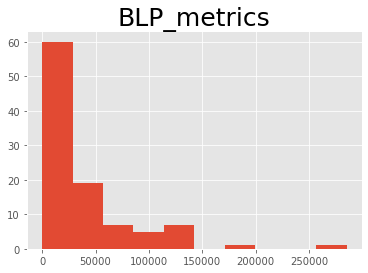

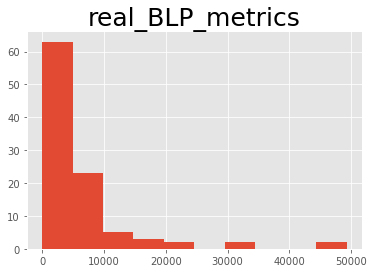

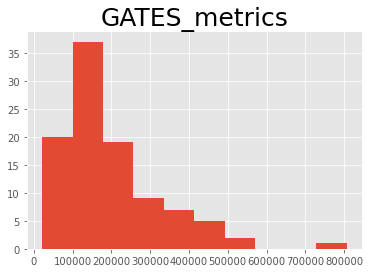

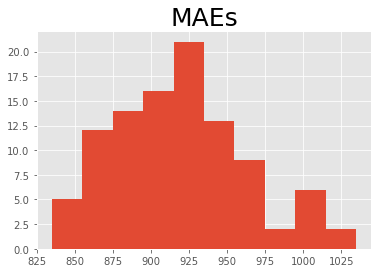

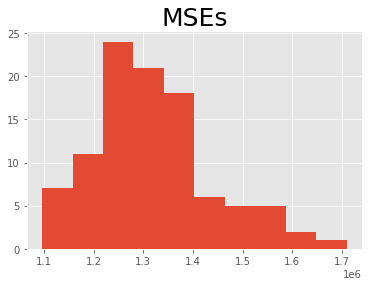

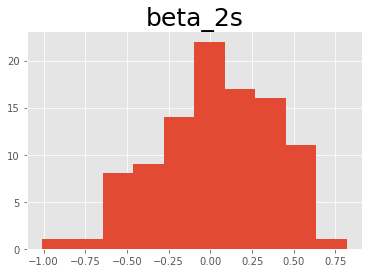

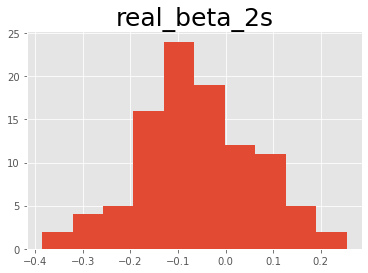

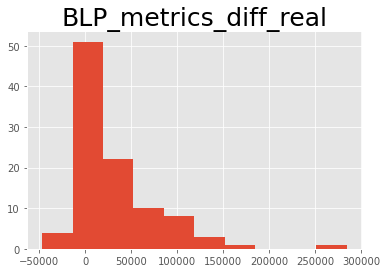

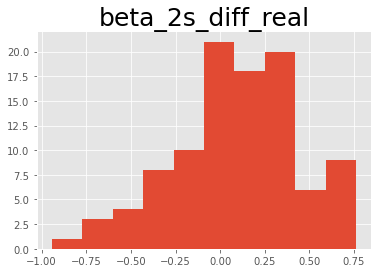

In [49]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.842e+04, tolerance: 1.151e+04
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<00:51,  1.93it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.414e+04, tolerance: 9.022e+03
  model = cd_fast.enet_coordinate_descent(
  2%|█▋                                                       

 18%|██████████████▌                                                                  | 18/100 [00:09<00:41,  1.98it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e+04, tolerance: 1.186e+04
  model = cd_fast.enet_coordinate_descent(
 19%|███████████████▍                                                                 | 19/100 [00:09<00:40,  1.98it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.846e+04, tolerance: 9.987e+03
  model = cd_fast.enet_coordinate_descent(
 20%|████████████████▏                                        

 36%|█████████████████████████████▏                                                   | 36/100 [00:18<00:33,  1.88it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.479e+04, tolerance: 1.099e+04
  model = cd_fast.enet_coordinate_descent(
 37%|█████████████████████████████▉                                                   | 37/100 [00:19<00:33,  1.89it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.493e+04, tolerance: 8.897e+03
  model = cd_fast.enet_coordinate_descent(
 38%|██████████████████████████████▊                          

 54%|███████████████████████████████████████████▋                                     | 54/100 [00:27<00:23,  1.96it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.220e+04, tolerance: 8.149e+03
  model = cd_fast.enet_coordinate_descent(
 55%|████████████████████████████████████████████▌                                    | 55/100 [00:27<00:23,  1.93it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e+04, tolerance: 1.109e+04
  model = cd_fast.enet_coordinate_descent(
 56%|█████████████████████████████████████████████▎           

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:36<00:14,  1.93it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.851e+04, tolerance: 5.908e+03
  model = cd_fast.enet_coordinate_descent(
 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:37<00:14,  1.93it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.974e+04, tolerance: 8.080e+03
  model = cd_fast.enet_coordinate_descent(
 74%|█████████████████████████████████████████████████████████

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:45<00:05,  1.98it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.884e+04, tolerance: 9.709e+03
  model = cd_fast.enet_coordinate_descent(
 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:46<00:04,  2.02it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.719e+04, tolerance: 9.615e+03
  model = cd_fast.enet_coordinate_descent(
 92%|█████████████████████████████████████████████████████████

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,35832.919190,211224.475440,903.291330,1.282834e+06,5529.779880,0.088680,-0.028770
std,45854.413798,146325.193418,50.548809,1.231189e+05,5982.049829,0.350661,0.141359
min,39.534000,19488.748000,776.888000,1.012595e+06,3.561000,-0.968000,-0.313000
25%,5439.426750,108800.214750,866.640000,1.185938e+06,831.646000,-0.133750,-0.145500
50%,19292.414000,173881.957500,906.084000,1.298635e+06,3330.778000,0.135000,-0.024000
75%,43072.012750,282265.226000,940.088500,1.373499e+06,8311.067000,0.350500,0.072250
max,202944.709000,803776.320000,1049.756000,1.562706e+06,23363.290000,0.764000,0.306000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-57.336,-1562.483,1459.191,-1278.267,-1518.674,-1053.902
G2,201.703,-1216.833,1591.954,-425.885,-528.332,-320.747
G3,-7.264,-1340.181,1302.434,126.538,61.150,185.582
G4,15.963,-1379.174,1329.469,566.923,495.061,640.806
G5,102.818,-1307.523,1516.482,1431.655,1166.686,1710.888


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-57.336,-1562.483,1459.191,-1278.267,-1518.674,-1053.902
x1,1.026,0.389,1.656,1.082,0.542,1.629
x4,9.142,7.439,10.822,8.927,7.265,10.565
x5,35.380,31.152,39.146,35.379,31.782,38.866
x6,-6.451,-9.710,-3.218,-7.850,-11.283,-4.399
...,...,...,...,...,...,...
x1270,-0.884,-2.583,0.710,-1.871,-3.414,-0.304
x1271,0.331,-0.957,1.678,0.211,-1.220,1.649
x1272,2.111,0.476,3.729,1.283,-0.521,3.119
x1273,0.206,-1.850,2.260,-0.585,-2.450,1.295


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,102.818,-1307.523,1516.482,1431.655,1166.686,1710.888
x1,0.992,0.350,1.626,1.014,0.369,1.654
x4,9.228,7.702,10.692,9.329,7.514,11.193
x5,34.800,31.046,38.355,35.814,31.239,40.357
x6,-6.422,-9.565,-3.390,-5.594,-8.638,-2.419
...,...,...,...,...,...,...
x1270,-1.217,-2.803,0.350,-0.724,-2.169,0.646
x1271,0.681,-0.745,2.115,0.829,-0.521,2.209
x1272,1.592,-0.014,3.208,1.421,-0.177,2.971
x1273,0.317,-1.677,2.387,0.528,-1.571,2.642


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,140.424,-1915.625,2187.619,2699.671,2353.299,3054.660
x1,-0.067,-0.943,0.830,-0.049,-0.904,0.795
x4,0.093,-2.155,2.311,0.502,-1.891,2.919
x5,-0.358,-5.796,5.145,0.602,-5.115,6.287
x6,-0.004,-4.691,4.505,2.156,-2.479,6.785
...,...,...,...,...,...,...
x1270,-0.329,-2.695,2.059,1.224,-0.929,3.304
x1271,0.375,-1.635,2.379,0.648,-1.322,2.620
x1272,-0.375,-2.705,1.906,0.190,-2.287,2.620
x1273,0.272,-2.584,3.057,1.088,-1.802,3.928


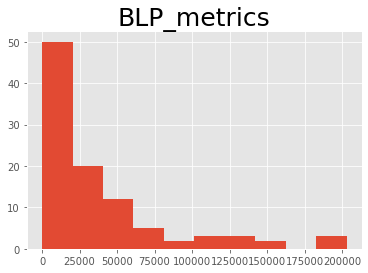

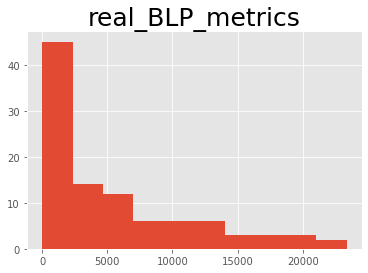

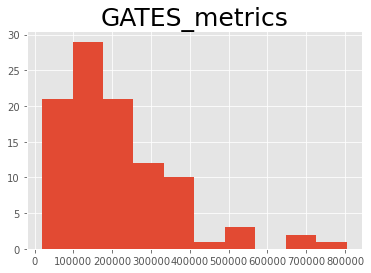

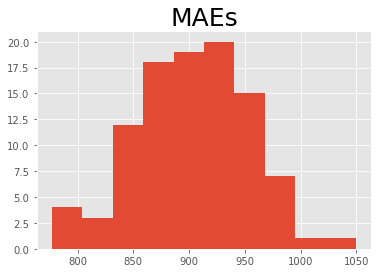

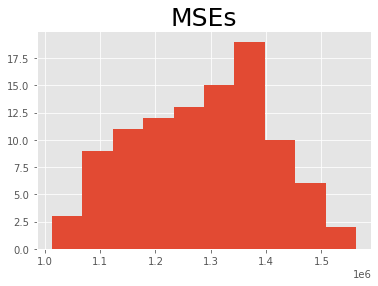

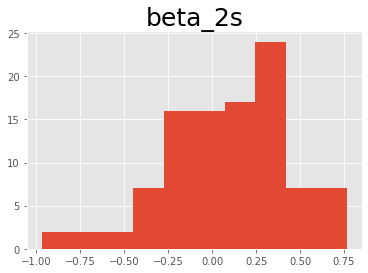

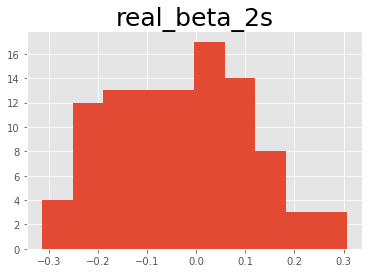

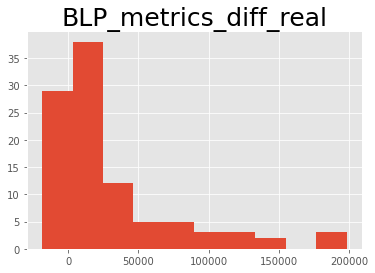

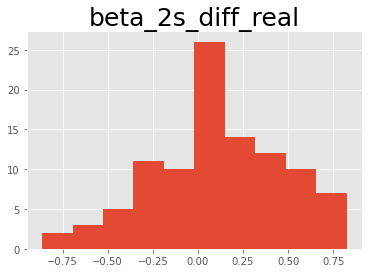

In [50]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = elast1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,29002.604320,200999.410020,818.194580,1.066377e+06,5978.088640,-0.050660,-0.134810
std,45350.115397,129068.523794,42.624915,1.004767e+05,7274.422873,0.644043,0.255641
min,3.970000,13294.963000,729.679000,8.507390e+05,0.320000,-1.352000,-0.690000
25%,3016.514000,105330.096500,794.621250,9.991078e+05,764.934250,-0.527250,-0.301750
50%,12498.529000,176518.938000,813.712500,1.058928e+06,2779.140500,-0.081500,-0.158500
75%,37394.067000,259335.207250,843.838250,1.124987e+06,8937.004000,0.341500,0.067250
max,316750.025000,603232.760000,956.081000,1.386097e+06,34562.125000,1.981000,0.441000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,156.212,-1358.612,1674.361,-1267.366,-1496.241,-1035.404
G2,83.272,-1336.959,1479.849,-421.864,-523.868,-322.695
G3,-7.875,-1354.362,1457.022,129.444,63.683,187.507
G4,-25.490,-1416.098,1399.926,580.423,502.361,656.237
G5,0.674,-1382.538,1403.863,1447.740,1182.878,1736.165


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,156.212,-1358.612,1674.361,-1267.366,-1496.241,-1035.404
x1,1.023,0.393,1.669,1.110,0.568,1.653
x4,9.302,7.617,10.941,8.870,7.173,10.552
x5,35.554,31.818,39.469,35.183,31.694,38.707
x6,-6.568,-9.988,-3.291,-7.816,-11.196,-4.274
...,...,...,...,...,...,...
x1270,-1.000,-2.437,0.494,-1.892,-3.489,-0.387
x1271,0.146,-1.111,1.379,0.177,-1.232,1.556
x1272,1.850,0.217,3.521,1.218,-0.583,2.992
x1273,-0.162,-2.136,1.843,-0.604,-2.512,1.324


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,0.674,-1382.538,1403.863,1447.740,1182.878,1736.165
x1,1.032,0.412,1.672,1.012,0.359,1.645
x4,9.046,7.525,10.595,9.385,7.457,11.292
x5,34.512,30.587,38.318,35.766,31.065,40.341
x6,-6.369,-9.529,-3.305,-5.684,-8.848,-2.561
...,...,...,...,...,...,...
x1270,-1.071,-2.783,0.636,-0.580,-1.969,0.805
x1271,1.126,-0.356,2.533,0.796,-0.525,2.176
x1272,2.102,0.448,3.688,1.440,-0.173,3.016
x1273,0.841,-1.350,2.968,0.599,-1.550,2.676


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-240.206,-2224.903,1809.073,2731.614,2365.474,3078.119
x1,0.008,-0.868,0.915,-0.104,-0.943,0.751
x4,-0.183,-2.515,2.004,0.513,-1.971,3.044
x5,-0.994,-6.398,4.317,0.345,-5.310,6.133
x6,0.333,-4.262,4.898,2.199,-2.428,6.791
...,...,...,...,...,...,...
x1270,-0.070,-2.385,2.172,1.296,-0.711,3.378
x1271,0.995,-0.846,2.822,0.643,-1.286,2.559
x1272,0.196,-2.062,2.431,0.193,-2.195,2.589
x1273,0.925,-1.969,3.864,1.107,-1.695,3.997


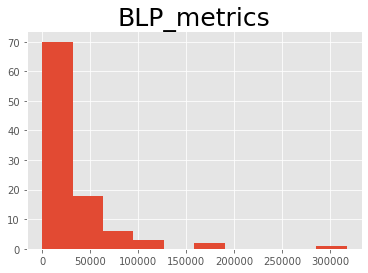

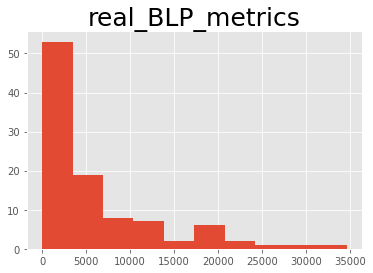

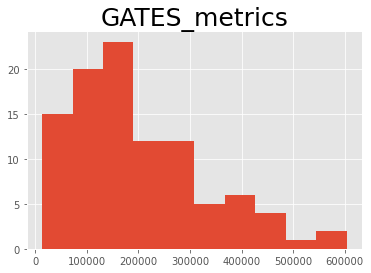

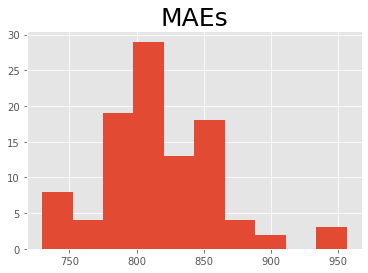

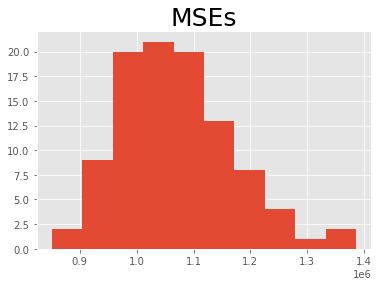

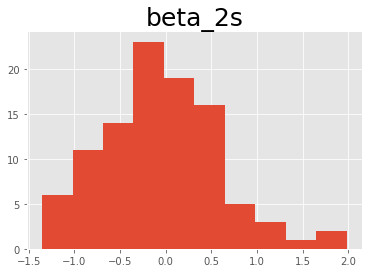

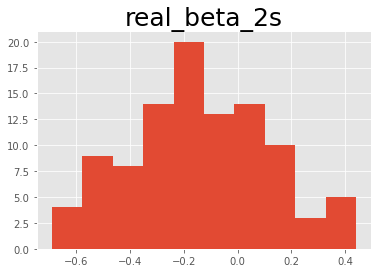

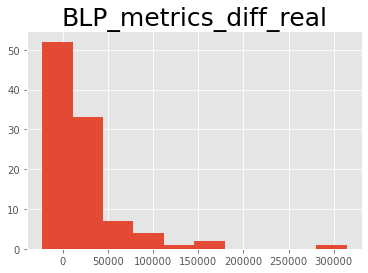

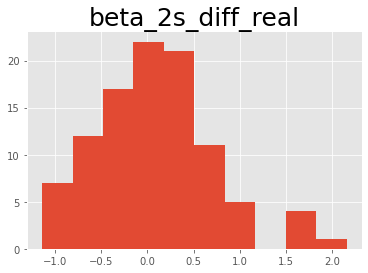

In [51]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = elast0_tune_MSE, model1 = ElasticNet(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

### c) Tuning Lgbm: tuning 1 model, first model for B(X) is obtained from tuning MSE

# IF RUNNING THE WHOLE FILE, COMMENT THE CELL BELOW!!!

In [52]:
# WRITE DOWN THE OPTIMAL PARAMETERS HERE!!!!
# IF RUNNING THE WHOLE FILE, COMMENT THIS CELL!!!!
# lgbm0_tune_MSE = LGBMRegressor(colsample_bytree=1, 
#                                min_child_weight=0.0001, 
#                                min_split_gain=0,
#                                n_estimators=50, 
#                                num_leaves=20, 
#                                silent=False)

# lgbm1_tune_MSE = LGBMRegressor(colsample_bytree=0.8, 
#                                learning_rate=0.05, 
#                                min_child_weight=0.0001,
#                                min_split_gain=0,
#                                n_estimators=200, 
#                                num_leaves=20, 
#                                silent=False)

### 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)

In [53]:
# 3 models for CV A sample where D = 0!!!! Hyperparameter are 'optimal MSE' ones (minimise MSE for B(X) estimation!!!!!)
lgbm0_tune_MSE1 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'],
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE2 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

lgbm0_tune_MSE3 = LGBMRegressor(colsample_bytree = lgbm0_tune_MSE.get_params()['colsample_bytree'], 
                               min_child_weight = lgbm0_tune_MSE.get_params()['min_child_weight'], 
                               min_split_gain = lgbm0_tune_MSE.get_params()['min_split_gain'],
                               n_estimators = lgbm0_tune_MSE.get_params()['n_estimators'], 
                               num_leaves = lgbm0_tune_MSE.get_params()['num_leaves'], 
                               learning_rate = lgbm0_tune_MSE.get_params()['learning_rate'],
                               silent = lgbm0_tune_MSE.get_params()['silent'])

## Creating 3 OOF samples where D = 0 to join them with OOF samples where D = 1 to imitate the whole OOF sample in general (B sample), on which all metrics are calculated!!!!! And making corresponding fit of rf0_tune_MSE on all data apart from OOF!!!
### For B(X) model is already tuned (minimising MSE), so no need to fit every time later, since optimizing hyperparameters are known (can fit once in the cell below for each fold)!!!!!

In [54]:
# all three models in the list will be fitted and used 
    # to predict B(X) for OOF immitation of B sample later!!!!
list_models0 = [lgbm0_tune_MSE1, lgbm0_tune_MSE2, lgbm0_tune_MSE3]
OOF0_samples = []
scalers0 = []

i = 0
for train_index, test_index in KFold(n_splits = 3).split(df_A_0):
    tr_index = train_index
    te_index = test_index 
    
    df_train = df_A_0.iloc[tr_index].copy()
    df_test = df_A_0.iloc[te_index].copy()
    X_train = df_train[x_cols]
    y_train = df_train['y']
    X_pred = df_test[x_cols]
    # MinMaxSCALER!!!!! (as mentioned in paper)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scalers0.append(scaler)
    # optimal MSE tuned model for D = 0 but fit on 'train' A data where D = 0
    model = list_models0[i]
    model.fit(scaler.transform(X_train), y_train)
    
    # appending needed data
    OOF0_samples.append(df_test)
    # fitted scalers
    scalers0.append(scaler)
    i += 1

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -161.797180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightG

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


In [55]:
# tuning based on CV Lambda_hat score, done BackBone!
init_lambda_hat = 0
best_lambda_hat = init_lambda_hat
best_params = {}
i = 0

for colsample_bytree in tqdm_notebook([0.02, 0.05, 0.07, 0.1]):
    for learning_rate in tqdm([0.003, 0.005, 0.01, 0.03, 0.05, 0.07]):
        for num_leaves in tqdm([2, 3, 5]):
            for min_split_gain in [0, 0.0001]:
                for min_child_weight in [0, 0.0001, 0.01]:
                    for n_estimators in [2, 3]:
                        
                        rf_sup = LGBMRegressor(colsample_bytree = colsample_bytree, 
                                               learning_rate = learning_rate, 
                                               num_leaves = num_leaves, 
                                               min_split_gain = min_split_gain, 
                                               min_child_weight = min_child_weight, 
                                               n_estimators = n_estimators)

                        cur_lambda_hat = lambda_hat_tuning_CV(model1 = rf_sup, df1 = df_A_1, 
                                                      x_cols = x_cols, list_models0 = list_models0, 
                                                      OOF0_samples = OOF0_samples, scalers0 = scalers0)
                        
                        if cur_lambda_hat > best_lambda_hat: 
                            i += 1
                            best_lambda_hat = cur_lambda_hat
                            best_params['colsample_bytree'] = colsample_bytree
                            best_params['learning_rate'] = learning_rate
                            best_params['num_leaves'] = num_leaves
                            best_params['min_split_gain'] = min_split_gain
                            best_params['min_child_weight'] = min_child_weight
                            best_params['n_estimators'] = n_estimators
                            if i % 2 == 0:
                                print(best_lambda_hat)
                                print(best_params)

C:\Users\052\AppData\Local\Temp\ipykernel_11292\3792495456.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for colsample_bytree in tqdm_notebook([0.02, 0.05, 0.07, 0.1]):


  0%|          | 0/4 [00:00<?, ?it/s]


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:05<00:11,  5.81s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:11<00:05,  5.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.84s/it]

 17%|██████████████                                                                      | 1/6 [00:17<01:27, 17.51s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:05<00:11,  5.74s/it]

 67%|██████████████████████████

In [56]:
best_params, best_lambda_hat

({'colsample_bytree': 0.02,
  'learning_rate': 0.003,
  'num_leaves': 2,
  'min_split_gain': 0,
  'min_child_weight': 0,
  'n_estimators': 2},
 180523.5094820256)

In [57]:
lgbm1_tune_Lambda_hat = LGBMRegressor(colsample_bytree = best_params['colsample_bytree'], 
                                               learning_rate = best_params['learning_rate'], 
                                               num_leaves = best_params['num_leaves'], 
                                               min_split_gain = best_params['min_split_gain'], 
                                               min_child_weight = best_params['min_child_weight'], 
                                               n_estimators = best_params['n_estimators'])

### General (non-pairwise) comparison of 3 lgbm specifications: target tuned, MSE tuned, default!!

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -272.357989


  1%|▊                                                                                 | 1/100 [00:00<00:55,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -107.329774


  2%|█▋                                                                                | 2/100 [00:01<00:58,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -108.437572


  3%|██▍                                                                               | 3/100 [00:01<00:57,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -23.291799


  4%|███▎                                                                              | 4/100 [00:02<00:57,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 23.712293


  5%|████                                                                              | 5/100 [00:02<00:55,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -254.134643


  6%|████▉                                                                             | 6/100 [00:03<00:55,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 71.020200


  7%|█████▋                                                                            | 7/100 [00:04<00:54,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -243.779494


  8%|██████▌                                                                           | 8/100 [00:04<00:53,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -82.209016


  9%|███████▍                                                                          | 9/100 [00:05<00:52,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -304.694942


 10%|████████                                                                         | 10/100 [00:05<00:52,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -256.993118


 11%|████████▉                                                                        | 11/100 [00:06<00:52,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -157.675431


 12%|█████████▋                                                                       | 12/100 [00:07<00:51,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -277.154253


 13%|██████████▌                                                                      | 13/100 [00:07<00:50,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -163.452473


 14%|███████████▎                                                                     | 14/100 [00:08<00:55,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -79.579898


 15%|████████████▏                                                                    | 15/100 [00:08<00:52,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -70.658655


 16%|████████████▉                                                                    | 16/100 [00:09<00:51,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -88.879447


 17%|█████████████▊                                                                   | 17/100 [00:10<00:50,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -271.734122


 18%|██████████████▌                                                                  | 18/100 [00:10<00:48,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -89.713563


 19%|███████████████▍                                                                 | 19/100 [00:11<00:48,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -243.195902


 20%|████████████████▏                                                                | 20/100 [00:11<00:47,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -15.570449


 21%|█████████████████                                                                | 21/100 [00:12<00:46,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -129.325408


 22%|█████████████████▊                                                               | 22/100 [00:13<00:45,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -82.424150


 23%|██████████████████▋                                                              | 23/100 [00:13<00:45,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -92.827650


 24%|███████████████████▍                                                             | 24/100 [00:14<00:43,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 58.279026


 25%|████████████████████▎                                                            | 25/100 [00:14<00:43,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -78.379923


 26%|█████████████████████                                                            | 26/100 [00:15<00:42,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -165.565038


 27%|█████████████████████▊                                                           | 27/100 [00:15<00:41,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -251.638552


 28%|██████████████████████▋                                                          | 28/100 [00:16<00:41,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -120.960411


 29%|███████████████████████▍                                                         | 29/100 [00:17<00:40,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -97.153994


 30%|████████████████████████▎                                                        | 30/100 [00:17<00:40,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -81.788706


 31%|█████████████████████████                                                        | 31/100 [00:18<00:38,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -155.060308


 32%|█████████████████████████▉                                                       | 32/100 [00:18<00:38,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -201.263336


 33%|██████████████████████████▋                                                      | 33/100 [00:19<00:37,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -67.257295


 34%|███████████████████████████▌                                                     | 34/100 [00:19<00:37,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -140.257331


 35%|████████████████████████████▎                                                    | 35/100 [00:20<00:36,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -43.561476


 36%|█████████████████████████████▏                                                   | 36/100 [00:20<00:35,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -95.156753


 37%|█████████████████████████████▉                                                   | 37/100 [00:21<00:35,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -90.750925


 38%|██████████████████████████████▊                                                  | 38/100 [00:22<00:34,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -50.514064


 39%|███████████████████████████████▌                                                 | 39/100 [00:22<00:34,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -151.350751


 40%|████████████████████████████████▍                                                | 40/100 [00:23<00:33,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -105.916481


 41%|█████████████████████████████████▏                                               | 41/100 [00:23<00:32,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 31.570540


 42%|██████████████████████████████████                                               | 42/100 [00:24<00:32,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -117.649060


 43%|██████████████████████████████████▊                                              | 43/100 [00:24<00:31,  1.80it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -94.178765


 44%|███████████████████████████████████▋                                             | 44/100 [00:25<00:31,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score -92.692821


 45%|████████████████████████████████████▍                                            | 45/100 [00:26<00:31,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -224.501330


 46%|█████████████████████████████████████▎                                           | 46/100 [00:26<00:30,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -169.587043


 47%|██████████████████████████████████████                                           | 47/100 [00:27<00:29,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -134.892236


 48%|██████████████████████████████████████▉                                          | 48/100 [00:27<00:29,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -153.796587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 49%|███████████████████████████████████████▋                                         | 49/100 [00:28<00:28,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -118.097394


 50%|████████████████████████████████████████▌                                        | 50/100 [00:28<00:28,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -180.557089


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:29<00:27,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -263.207778


 52%|██████████████████████████████████████████                                       | 52/100 [00:29<00:26,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -169.711841


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:30<00:26,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -103.487478


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:31<00:25,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -194.863539


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:31<00:25,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -198.945293


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:32<00:25,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -232.729203


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:32<00:24,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -81.206237


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:33<00:24,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -105.246264


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:34<00:24,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -240.992224


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:34<00:23,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -40.486835


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:35<00:23,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -115.889742


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:35<00:22,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -25.732231


 63%|███████████████████████████████████████████████████                              | 63/100 [00:36<00:21,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -178.708114


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:36<00:20,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -77.747114


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:37<00:20,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -169.099533


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:38<00:19,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -187.197430


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:38<00:18,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -142.596397


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:39<00:18,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -189.987675


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:39<00:18,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -233.173278


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:40<00:17,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -115.365886


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:41<00:16,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -171.706854


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:41<00:16,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -126.156736


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:42<00:16,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -309.151371


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:42<00:15,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -72.913376


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:43<00:14,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -140.922167


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:43<00:13,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -121.516745


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:44<00:13,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -179.597337


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:45<00:12,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -136.466938


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:45<00:12,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -128.837000


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:46<00:11,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -130.383423


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:46<00:11,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -103.849746


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:47<00:10,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -158.794757


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:48<00:09,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -223.332377


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:48<00:09,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -59.419206


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:49<00:08,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -6.714320


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:49<00:08,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -79.782546


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:50<00:07,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -141.382682


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:50<00:06,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -69.927524


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:51<00:06,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -50.206530


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:52<00:05,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -112.296553


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:52<00:05,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -216.452448


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:53<00:04,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -146.622333


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:53<00:03,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -129.509904


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:54<00:03,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -202.034046


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:54<00:02,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -102.807886


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:55<00:02,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -238.207875


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:56<00:01,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -195.447546


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:56<00:01,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -194.226899


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:57<00:00,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -203.861203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.00000,1.000000e+02,100.00000,100.00000,100.000000
mean,65538.817410,260461.609670,775.28375,9.637574e+05,8649.19460,26.35558,-0.340710
std,69325.185151,164309.802692,46.15764,1.010675e+05,11847.02681,126.74366,45.296539
min,20.387000,20321.954000,685.46100,7.675909e+05,0.44800,-235.58400,-106.248000
25%,5384.457000,144200.757250,743.39675,8.938730e+05,1079.36775,-69.78700,-29.048750
50%,44753.151000,223514.324500,770.85500,9.580001e+05,4168.69650,26.10700,3.126500
75%,99842.351000,344729.715000,795.80325,1.023130e+06,10883.60350,122.64050,34.586250
max,311383.622000,886222.299000,905.81500,1.235620e+06,70437.92600,290.34100,113.261000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-32.637,-1473.290,1384.442,-1289.695,-1516.981,-1061.792
G2,94.002,-1289.017,1524.247,-424.673,-525.896,-330.286
G3,53.463,-1413.398,1479.445,121.082,54.482,183.081
G4,7.601,-1452.186,1520.547,550.252,479.817,628.129
G5,119.624,-1290.366,1497.866,1409.906,1152.006,1682.396


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-32.637,-1473.290,1384.442,-1289.695,-1516.981,-1061.792
x1,1.039,0.431,1.621,1.086,0.550,1.620
x4,8.959,7.320,10.498,8.856,7.220,10.493
x5,34.615,30.935,38.702,35.202,31.697,38.791
x6,-6.181,-9.411,-3.052,-7.800,-11.331,-4.284
...,...,...,...,...,...,...
x1270,-1.153,-2.704,0.487,-1.855,-3.346,-0.343
x1271,0.463,-1.040,1.886,0.153,-1.275,1.624
x1272,1.818,0.279,3.477,1.225,-0.558,3.016
x1273,0.233,-1.782,2.200,-0.735,-2.614,1.242


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,119.624,-1290.366,1497.866,1409.906,1152.006,1682.396
x1,0.994,0.378,1.589,1.032,0.397,1.673
x4,9.067,7.511,10.682,9.553,7.690,11.348
x5,34.772,30.911,38.493,36.121,31.661,40.474
x6,-6.164,-9.341,-2.951,-5.558,-8.614,-2.366
...,...,...,...,...,...,...
x1270,-1.049,-2.541,0.540,-0.662,-2.002,0.725
x1271,0.522,-0.866,1.968,0.844,-0.586,2.295
x1272,1.959,0.486,3.498,1.542,-0.101,3.163
x1273,0.397,-1.674,2.542,0.626,-1.458,2.647


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,60.315,-1925.765,2041.702,2712.668,2363.168,3063.596
x1,-0.043,-0.884,0.805,-0.079,-0.901,0.777
x4,0.092,-2.136,2.343,0.688,-1.750,3.154
x5,0.113,-5.239,5.463,0.840,-4.842,6.483
x6,0.044,-4.379,4.606,2.268,-2.464,7.021
...,...,...,...,...,...,...
x1270,0.078,-2.189,2.342,1.271,-0.854,3.305
x1271,0.060,-1.898,2.073,0.655,-1.335,2.689
x1272,0.024,-2.170,2.236,0.261,-2.155,2.705
x1273,0.359,-2.561,3.100,1.208,-1.589,3.985


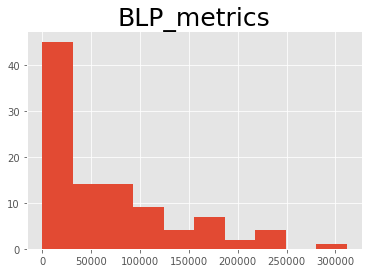

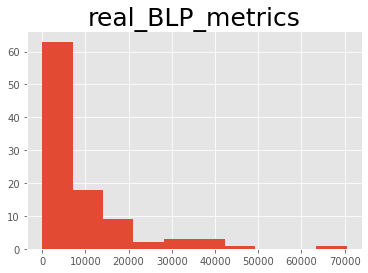

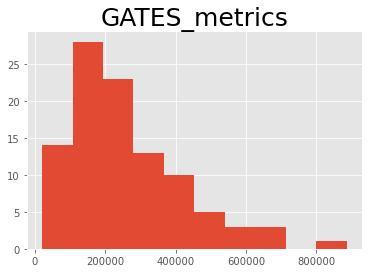

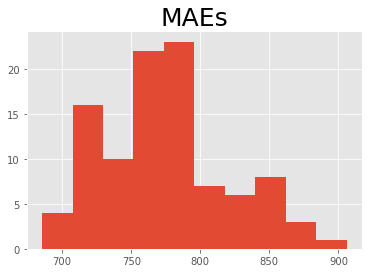

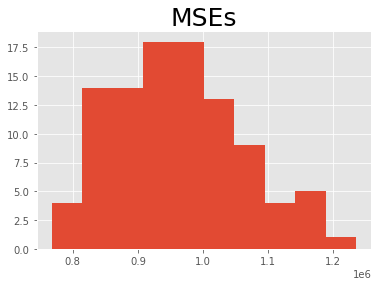

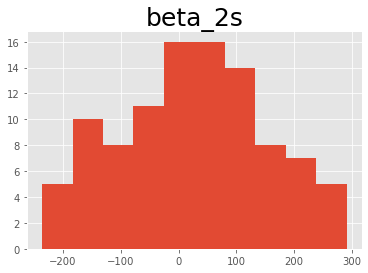

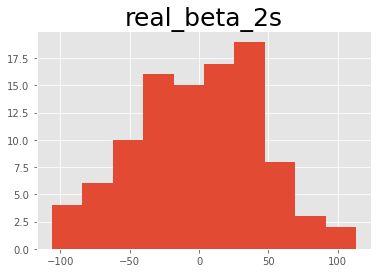

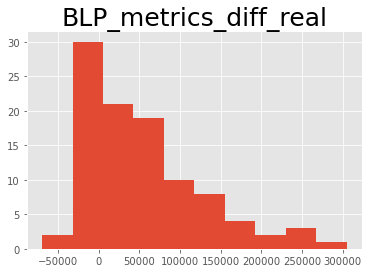

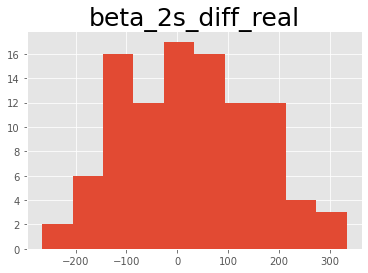

In [58]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_Lambda_hat, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -159.712819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 223.487122


  1%|▊                                                                                 | 1/100 [00:00<00:57,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -90.287339


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score 341.527880


  2%|█▋                                                                                | 2/100 [00:01<00:56,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -131.522884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 123.303924


  3%|██▍                                                                               | 3/100 [00:01<00:56,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -61.444818


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score 165.029498


  4%|███▎                                                                              | 4/100 [00:02<00:56,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 54.788925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -6.489502


  5%|████                                                                              | 5/100 [00:02<00:55,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -73.272705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score -109.053676


  6%|████▉                                                                             | 6/100 [00:03<00:54,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -129.452935
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 292.719603


  7%|█████▋                                                                            | 7/100 [00:04<00:53,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -119.824891
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 237.696042


  8%|██████▌                                                                           | 8/100 [00:04<00:53,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -179.873754


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 402.187682


  9%|███████▍                                                                          | 9/100 [00:05<00:52,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -115.475988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 151.443990


 10%|████████                                                                         | 10/100 [00:05<00:52,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -80.353548


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -219.667803


 11%|████████▉                                                                        | 11/100 [00:06<00:51,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -148.649335


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 287.800989


 12%|█████████▋                                                                       | 12/100 [00:07<00:52,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -103.187038
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -36.507351


 13%|██████████▌                                                                      | 13/100 [00:07<00:51,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -83.818993
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 165.749838


 14%|███████████▎                                                                     | 14/100 [00:08<00:49,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -85.604586


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -17.984017


 15%|████████████▏                                                                    | 15/100 [00:08<00:49,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -96.818934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -167.070479


 16%|████████████▉                                                                    | 16/100 [00:09<00:48,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -200.365577
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 179.053304


 17%|█████████████▊                                                                   | 17/100 [00:09<00:47,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -136.986217


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -225.383882


 18%|██████████████▌                                                                  | 18/100 [00:10<00:47,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -172.124074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004313 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 165.537477


 19%|███████████████▍                                                                 | 19/100 [00:11<00:46,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -100.039303
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 46.638865


 20%|████████████████▏                                                                | 20/100 [00:11<00:45,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -25.665615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score -69.803699


 21%|█████████████████                                                                | 21/100 [00:12<00:46,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -214.447769


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score 87.292741


 22%|█████████████████▊                                                               | 22/100 [00:12<00:45,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -234.844481
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 95.622590


 23%|██████████████████▋                                                              | 23/100 [00:13<00:44,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -55.257780


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score -85.889486


 24%|███████████████████▍                                                             | 24/100 [00:13<00:44,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -114.331001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004742 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -57.554475


 25%|████████████████████▎                                                            | 25/100 [00:14<00:43,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -272.672058


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 211.538862


 26%|█████████████████████                                                            | 26/100 [00:15<00:42,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -71.954045
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003603 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 166.804381


 27%|█████████████████████▊                                                           | 27/100 [00:15<00:42,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -118.174337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 413.346890


 28%|██████████████████████▋                                                          | 28/100 [00:16<00:41,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -138.116544


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 187.803678


 29%|███████████████████████▍                                                         | 29/100 [00:16<00:40,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -165.221594


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 398.010848


 30%|████████████████████████▎                                                        | 30/100 [00:17<00:40,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score 37.068772


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -213.355494


 31%|█████████████████████████                                                        | 31/100 [00:17<00:39,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -182.585828
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 38.820469


 32%|█████████████████████████▉                                                       | 32/100 [00:18<00:38,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -80.897851
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -269.634568


 33%|██████████████████████████▋                                                      | 33/100 [00:19<00:38,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -36.526693


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -73.073005


 34%|███████████████████████████▌                                                     | 34/100 [00:19<00:37,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -11.935776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 111.942339


 35%|████████████████████████████▎                                                    | 35/100 [00:20<00:36,  1.77it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -221.763321


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 102.158013


 36%|█████████████████████████████▏                                                   | 36/100 [00:20<00:36,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -20.916869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -268.475238


 37%|█████████████████████████████▉                                                   | 37/100 [00:21<00:35,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -97.923250


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 4.620199


 38%|██████████████████████████████▊                                                  | 38/100 [00:21<00:35,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -73.772626
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 129.869932


 39%|███████████████████████████████▌                                                 | 39/100 [00:22<00:34,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -110.851368


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 149.673941


 40%|████████████████████████████████▍                                                | 40/100 [00:23<00:34,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -87.373156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004448 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 58.624078


 41%|█████████████████████████████████▏                                               | 41/100 [00:23<00:33,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -235.552446


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -108.015721


 42%|██████████████████████████████████                                               | 42/100 [00:24<00:33,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -176.095449


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -30.824797


 43%|██████████████████████████████████▊                                              | 43/100 [00:24<00:32,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -116.575827


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 0.735434


 44%|███████████████████████████████████▋                                             | 44/100 [00:25<00:32,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -47.795700
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -456.514807


 45%|████████████████████████████████████▍                                            | 45/100 [00:25<00:31,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score 17.351371


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score 129.724328


 46%|█████████████████████████████████████▎                                           | 46/100 [00:26<00:30,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 15.040999


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -42.331860


 47%|██████████████████████████████████████                                           | 47/100 [00:27<00:30,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -115.607676
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -14.643899


 48%|██████████████████████████████████████▉                                          | 48/100 [00:27<00:29,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -87.789053


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -378.824070


 49%|███████████████████████████████████████▋                                         | 49/100 [00:28<00:29,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -189.119514
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 152.710435


 50%|████████████████████████████████████████▌                                        | 50/100 [00:28<00:28,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -65.490553


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -179.927758


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:29<00:28,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -78.983002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -115.351223


 52%|██████████████████████████████████████████                                       | 52/100 [00:29<00:27,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 70.437903


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -103.647492


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:30<00:26,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -66.528412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 20.157045


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:31<00:26,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -47.395083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -66.901082


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:31<00:25,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -46.549417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 5.969339


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:32<00:24,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -171.996144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 126.517901


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:32<00:24,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -141.634409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 175.949651


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:33<00:23,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 90, number of used features: 1264
[LightGBM] [Info] Start training from score -164.151138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 1264
[LightGBM] [Info] Start training from score -18.078417


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:33<00:22,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -154.029930
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 199.985879


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:34<00:22,  1.79it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -151.300804


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -44.096304


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:35<00:21,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -212.886843
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004557 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -114.664515


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:35<00:21,  1.78it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -200.912176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 233.332235


 63%|███████████████████████████████████████████████████                              | 63/100 [00:36<00:20,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -110.546796


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 15.351039


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:36<00:20,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -127.792325


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 97.319933


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:37<00:19,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -126.430684
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004807 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 196.115290


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:37<00:19,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -215.044698
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -5.404502


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:38<00:18,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -171.644393
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 20.841107


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:39<00:18,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -196.366868
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 147.990342


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:39<00:17,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -172.086143


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 139.810512


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:40<00:17,  1.74it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -68.278744
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 98.293915


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:40<00:16,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -87.668354
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -32.937834


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:41<00:15,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score 12.766234
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 154.206394


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:41<00:15,  1.76it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -126.952196


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -21.088716


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:42<00:14,  1.75it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -118.859471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -100.389666


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:43<00:14,  1.73it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -160.549231


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -131.046964


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:43<00:13,  1.72it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -230.989157
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 227.402787


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:44<00:13,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -194.275236
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 12.483432


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:44<00:13,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -4.834655
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -139.912521


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:45<00:12,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -84.344603


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score 116.581159


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:46<00:11,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score 87.676363


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score -165.596048


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:46<00:11,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -89.598467


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score -56.518253


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:47<00:10,  1.69it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -106.921105


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 119.012538


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:47<00:10,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -32.181043


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -160.140760


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:48<00:09,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -52.803407


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 336.378521


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:49<00:09,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -150.751705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 123.485399


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:49<00:08,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -231.441731


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 329.262190


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:50<00:08,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -124.997339
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 285.928390


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:50<00:07,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -55.029142
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -1.684304


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:51<00:06,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -66.174395


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -165.829200


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:52<00:06,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -163.657828


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score -5.780817


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:52<00:05,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -109.658443


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 112.826977


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:53<00:04,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -8.642407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -69.564204


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:53<00:04,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -78.775863
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 223.358154


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:54<00:03,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -124.164125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 296.588484


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:55<00:02,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -173.514013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -162.541515


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:55<00:02,  1.71it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -199.687028
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 126.750582


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:56<00:01,  1.70it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -54.302103


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score -28.601971


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:56<00:01,  1.68it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -209.614676
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004290 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 278.079770


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:57<00:00,  1.67it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -257.858570
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 208.047749


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.00000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,54062.24818,225098.446890,781.592910,9.766352e+05,7472.676060,31.873180,2.324090
std,73836.55119,132297.009302,45.062478,9.997832e+04,10673.036389,114.056035,45.072551
min,6.39300,30782.738000,673.909000,7.404893e+05,0.106000,-247.714000,-74.787000
25%,5804.19900,131289.192500,748.004500,9.068874e+05,548.757000,-51.872250,-30.712250
50%,24628.95400,219077.028000,775.103000,9.705499e+05,2945.722000,33.201500,-0.823000
75%,70386.01775,310547.686000,804.447250,1.028969e+06,10850.027500,97.708000,23.180000
max,324217.95600,695630.516000,919.228000,1.283757e+06,57260.135000,304.792000,167.261000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,18.990,-1414.537,1446.395,-1276.060,-1511.507,-1049.538
G2,184.220,-1250.853,1553.165,-424.543,-529.232,-318.936
G3,41.343,-1363.603,1477.083,119.627,62.496,181.664
G4,-17.420,-1472.975,1392.155,558.848,492.150,631.438
G5,265.976,-1150.949,1587.135,1428.669,1154.463,1700.326


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,18.990,-1414.537,1446.395,-1276.060,-1511.507,-1049.538
x1,1.059,0.456,1.661,1.055,0.531,1.612
x4,8.998,7.400,10.563,8.651,7.004,10.313
x5,34.963,31.022,38.688,34.888,31.268,38.485
x6,-6.278,-9.470,-3.087,-7.608,-11.079,-4.183
...,...,...,...,...,...,...
x1270,-1.096,-2.698,0.496,-1.842,-3.456,-0.323
x1271,0.356,-1.135,1.881,0.112,-1.336,1.557
x1272,1.793,0.178,3.474,1.163,-0.608,3.001
x1273,0.042,-1.976,2.064,-0.736,-2.609,1.187


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,265.976,-1150.949,1587.135,1428.669,1154.463,1700.326
x1,1.037,0.447,1.632,1.002,0.359,1.647
x4,9.093,7.564,10.611,9.475,7.671,11.219
x5,34.606,30.773,38.418,35.885,31.557,40.325
x6,-6.052,-9.074,-2.902,-5.517,-8.739,-2.252
...,...,...,...,...,...,...
x1270,-1.145,-2.655,0.415,-0.621,-1.997,0.774
x1271,0.614,-0.785,2.026,0.871,-0.501,2.231
x1272,1.832,0.267,3.389,1.490,-0.209,3.187
x1273,0.417,-1.738,2.576,0.581,-1.631,2.650


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,197.532,-1841.120,2283.817,2698.081,2343.572,3061.787
x1,-0.022,-0.872,0.844,-0.056,-0.896,0.791
x4,0.088,-2.129,2.358,0.684,-1.734,3.177
x5,-0.339,-5.807,5.159,0.884,-4.738,6.668
x6,0.206,-4.266,4.777,2.298,-2.448,6.933
...,...,...,...,...,...,...
x1270,0.083,-2.222,2.323,1.278,-0.793,3.384
x1271,0.222,-1.828,2.270,0.641,-1.329,2.684
x1272,-0.017,-2.335,2.163,0.332,-2.137,2.748
x1273,0.645,-2.389,3.631,1.185,-1.596,4.093


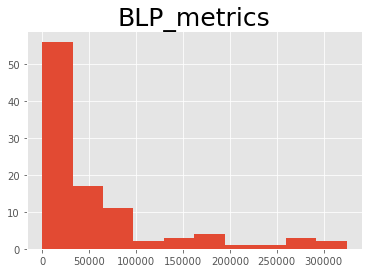

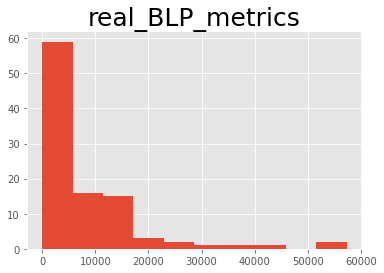

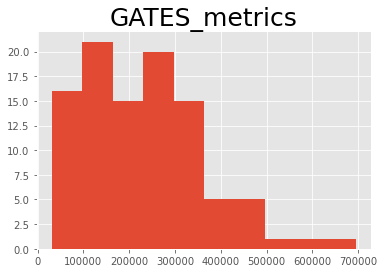

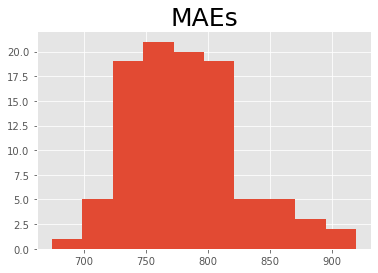

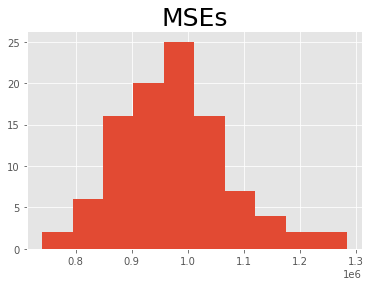

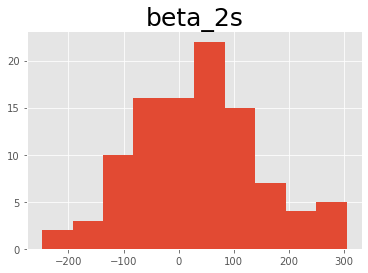

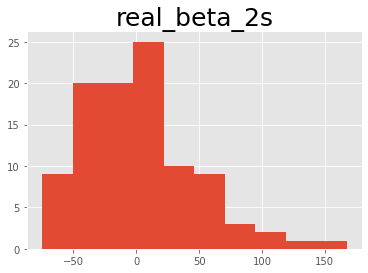

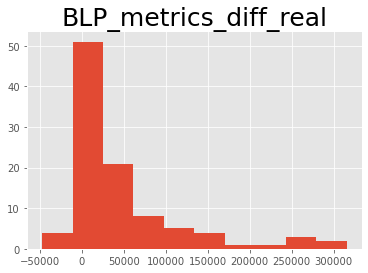

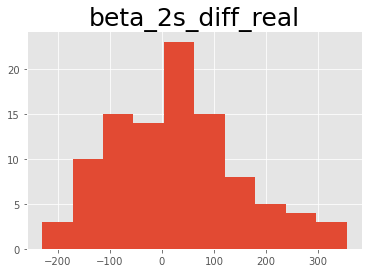

In [59]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = lgbm1_tune_MSE, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -14.454946


  1%|▊                                                                                 | 1/100 [00:00<01:13,  1.35it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -46.926594


  2%|█▋                                                                                | 2/100 [00:01<01:08,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -139.135263


  3%|██▍                                                                               | 3/100 [00:02<01:06,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -157.847843


  4%|███▎                                                                              | 4/100 [00:02<01:03,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -179.974706


  5%|████                                                                              | 5/100 [00:03<01:03,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -43.080697


  6%|████▉                                                                             | 6/100 [00:03<01:00,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -174.284883


  7%|█████▋                                                                            | 7/100 [00:04<00:59,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -62.125411


  8%|██████▌                                                                           | 8/100 [00:05<01:00,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -130.250714


  9%|███████▍                                                                          | 9/100 [00:05<00:59,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -119.367033


 10%|████████                                                                         | 10/100 [00:06<00:57,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -24.890426


 11%|████████▉                                                                        | 11/100 [00:07<00:56,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -195.218647


 12%|█████████▋                                                                       | 12/100 [00:07<00:56,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -110.809455


 13%|██████████▌                                                                      | 13/100 [00:08<00:55,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -2.012144


 14%|███████████▎                                                                     | 14/100 [00:09<00:56,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -248.285806


 15%|████████████▏                                                                    | 15/100 [00:09<00:55,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -14.968286


 16%|████████████▉                                                                    | 16/100 [00:10<00:56,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -143.314486


 17%|█████████████▊                                                                   | 17/100 [00:11<00:55,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -49.575821


 18%|██████████████▌                                                                  | 18/100 [00:11<00:53,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -348.854435


 19%|███████████████▍                                                                 | 19/100 [00:12<00:52,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -269.722686


 20%|████████████████▏                                                                | 20/100 [00:13<00:52,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -123.604966


 21%|█████████████████                                                                | 21/100 [00:13<00:52,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -88.158411


 22%|█████████████████▊                                                               | 22/100 [00:14<00:51,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 71, number of used features: 1264
[LightGBM] [Info] Start training from score -38.783153


 23%|██████████████████▋                                                              | 23/100 [00:15<00:50,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 71, number of used features: 1264
[LightGBM] [Info] Start training from score -93.415970


 24%|███████████████████▍                                                             | 24/100 [00:15<00:50,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -118.825555


 25%|████████████████████▎                                                            | 25/100 [00:16<00:48,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -120.527714


 26%|█████████████████████                                                            | 26/100 [00:17<00:46,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -230.339631


 27%|█████████████████████▊                                                           | 27/100 [00:17<00:45,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -149.316735


 28%|██████████████████████▋                                                          | 28/100 [00:18<00:45,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -83.518540


 29%|███████████████████████▍                                                         | 29/100 [00:18<00:44,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -275.782617


 30%|████████████████████████▎                                                        | 30/100 [00:19<00:44,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -158.338228


 31%|█████████████████████████                                                        | 31/100 [00:20<00:43,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -233.446772


 32%|█████████████████████████▉                                                       | 32/100 [00:20<00:44,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score 5.306731


 33%|██████████████████████████▋                                                      | 33/100 [00:21<00:44,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -84.170138


 34%|███████████████████████████▌                                                     | 34/100 [00:22<00:43,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -117.140072


 35%|████████████████████████████▎                                                    | 35/100 [00:22<00:43,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -140.662846


 36%|█████████████████████████████▏                                                   | 36/100 [00:23<00:42,  1.49it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -101.976002


 37%|█████████████████████████████▉                                                   | 37/100 [00:24<00:41,  1.50it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -64.754269


 38%|██████████████████████████████▊                                                  | 38/100 [00:24<00:41,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -132.822132


 39%|███████████████████████████████▌                                                 | 39/100 [00:25<00:40,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -23.133596


 40%|████████████████████████████████▍                                                | 40/100 [00:26<00:39,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -216.303913


 41%|█████████████████████████████████▏                                               | 41/100 [00:26<00:37,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score 14.626631


 42%|██████████████████████████████████                                               | 42/100 [00:27<00:37,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -95.624444


 43%|██████████████████████████████████▊                                              | 43/100 [00:28<00:36,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -163.737783


 44%|███████████████████████████████████▋                                             | 44/100 [00:28<00:36,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -58.683100


 45%|████████████████████████████████████▍                                            | 45/100 [00:29<00:35,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -225.182405


 46%|█████████████████████████████████████▎                                           | 46/100 [00:30<00:35,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -40.823275


 47%|██████████████████████████████████████                                           | 47/100 [00:30<00:33,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -140.956196


 48%|██████████████████████████████████████▉                                          | 48/100 [00:31<00:33,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -88.487783


 49%|███████████████████████████████████████▋                                         | 49/100 [00:31<00:33,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -67.635185


 50%|████████████████████████████████████████▌                                        | 50/100 [00:32<00:32,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -30.007742


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:33<00:31,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -85.775717


 52%|██████████████████████████████████████████                                       | 52/100 [00:33<00:30,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -136.052588


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:34<00:30,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -194.683408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:35<00:29,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -109.254386


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:35<00:28,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -20.416603


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:36<00:28,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -81.513936


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:37<00:28,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -152.400519


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:37<00:27,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -73.160175


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:38<00:26,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -166.556430


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:38<00:25,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -153.129456


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:39<00:24,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -101.445994


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:40<00:23,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -329.682947


 63%|███████████████████████████████████████████████████                              | 63/100 [00:40<00:23,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -89.225710


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:41<00:23,  1.54it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -176.465257


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:42<00:22,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -71.824359


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:42<00:21,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -178.283481


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:43<00:20,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -147.487056


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:44<00:20,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score 33.876243


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:44<00:20,  1.53it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -103.040833


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:45<00:19,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -78.204927


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:46<00:19,  1.46it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -93.073156


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:46<00:19,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -62.951701


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:47<00:18,  1.44it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -71.514525


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:48<00:17,  1.45it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 73.071656


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:48<00:16,  1.47it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -159.518250


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:49<00:15,  1.52it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -175.143464


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:50<00:15,  1.51it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -3.488741


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:50<00:14,  1.55it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -366.729506


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:51<00:13,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -20.936289


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:52<00:12,  1.56it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -227.245868


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:52<00:12,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -218.317992


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:53<00:11,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -96.193238


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:53<00:10,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -69.865904


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:54<00:10,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -135.145231


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:55<00:09,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -143.945143


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:55<00:08,  1.58it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -231.170971


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:56<00:08,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -179.156949


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:57<00:07,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -157.583177


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:57<00:06,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 1264
[LightGBM] [Info] Start training from score -143.155997


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:58<00:06,  1.59it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -9.342960


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:58<00:05,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -92.328176


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:59<00:04,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -125.999655


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:00<00:04,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -219.308181


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:00<00:03,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -136.830644


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:01<00:03,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -177.867367


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:02<00:02,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -131.885162


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:02<00:01,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -44.892449


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:03<00:01,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -211.596783


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:03<00:00,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -137.488225


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.55it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,49668.365080,213684.815520,915.309730,1.318824e+06,5389.331950,-0.043510,0.002620
std,56901.941794,125090.329188,53.769177,1.409656e+05,7044.154035,0.396897,0.129439
min,0.851000,18796.084000,778.723000,1.005381e+06,0.061000,-0.997000,-0.304000
25%,3322.044000,121927.076250,881.817500,1.224517e+06,605.342000,-0.288500,-0.071500
50%,19315.918000,212267.447500,918.280000,1.314527e+06,1944.666500,-0.048500,0.010000
75%,82677.875250,279439.848500,955.493750,1.419379e+06,7040.848750,0.179500,0.083250
max,206792.821000,602492.880000,1036.594000,1.744180e+06,28210.788000,0.846000,0.320000


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,-11.203,-1400.104,1409.664,-1290.143,-1514.765,-1059.716
G2,149.618,-1294.528,1500.721,-444.108,-545.011,-341.114
G3,127.508,-1337.734,1492.580,115.184,54.492,173.578
G4,53.827,-1382.017,1443.981,561.894,485.301,636.893
G5,31.438,-1486.959,1542.214,1444.018,1157.752,1725.447


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-11.203,-1400.104,1409.664,-1290.143,-1514.765,-1059.716
x1,1.023,0.401,1.645,1.083,0.552,1.620
x4,8.913,7.364,10.429,8.809,7.118,10.470
x5,34.648,30.862,38.499,35.097,31.677,38.677
x6,-6.473,-9.592,-3.385,-7.835,-11.285,-4.476
...,...,...,...,...,...,...
x1270,-1.190,-2.830,0.443,-1.858,-3.410,-0.353
x1271,0.442,-1.029,1.823,0.095,-1.356,1.549
x1272,1.796,0.094,3.472,1.199,-0.555,3.022
x1273,0.113,-1.861,2.097,-0.682,-2.558,1.265


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,31.438,-1486.959,1542.214,1444.018,1157.752,1725.447
x1,0.968,0.332,1.604,1.013,0.386,1.672
x4,9.124,7.600,10.631,9.460,7.649,11.126
x5,34.963,31.378,38.531,36.005,31.822,40.255
x6,-6.152,-9.544,-2.992,-5.528,-8.915,-2.376
...,...,...,...,...,...,...
x1270,-1.040,-2.651,0.466,-0.616,-1.969,0.740
x1271,0.598,-0.797,1.943,0.789,-0.569,2.235
x1272,1.798,0.232,3.307,1.491,-0.127,3.192
x1273,0.325,-1.833,2.409,0.441,-1.683,2.557


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-3.411,-2077.433,2097.170,2731.444,2355.496,3100.188
x1,0.016,-0.870,0.889,-0.075,-0.924,0.761
x4,0.209,-1.989,2.397,0.679,-1.832,3.054
x5,0.386,-5.069,5.523,0.943,-4.631,6.352
x6,0.274,-4.119,4.806,2.129,-2.625,6.860
...,...,...,...,...,...,...
x1270,0.053,-2.172,2.355,1.232,-0.797,3.306
x1271,0.202,-1.760,2.166,0.709,-1.331,2.732
x1272,-0.130,-2.404,2.155,0.247,-2.117,2.634
x1273,0.015,-2.860,2.858,1.088,-1.726,3.954


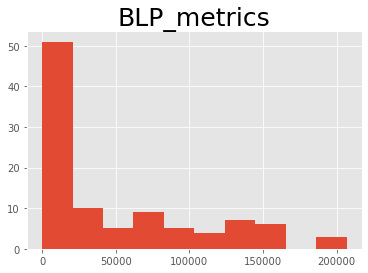

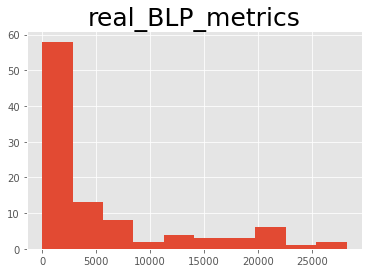

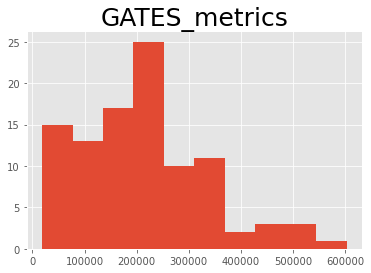

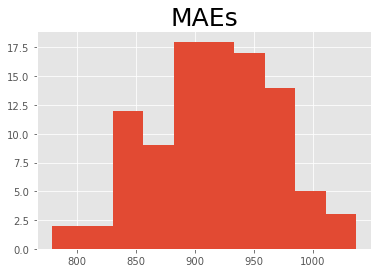

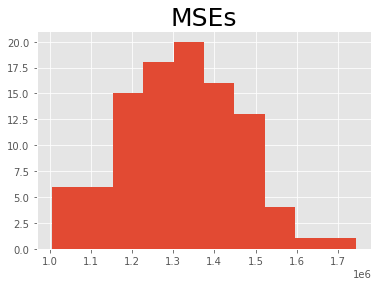

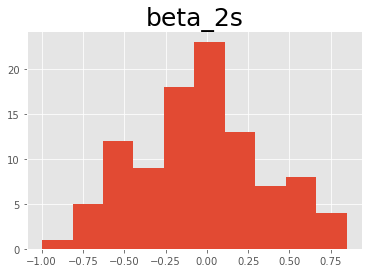

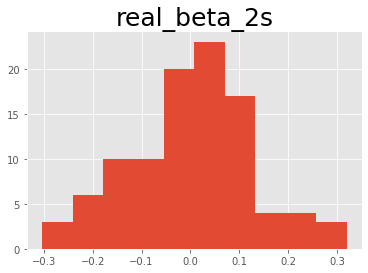

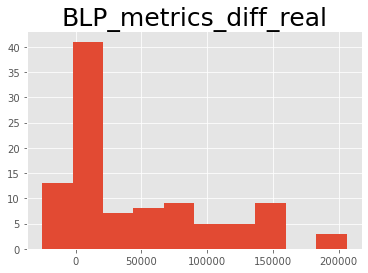

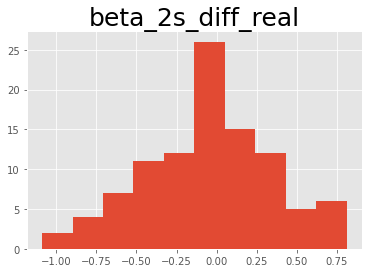

In [60]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = lgbm0_tune_MSE, model1 = LGBMRegressor(), 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

# 3) Comparing two models (MSE tune VS target tuning) , given datasplit!!! For rf, ElasticNet and lgbm

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:57<00:00,  5.98s/it]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.000000,100.000000
mean,-186.906700,-15919.899230,12.478240,30913.919260
std,88368.201983,190048.525507,16.218657,38119.101502
min,-309924.217000,-518239.739000,-18.694000,-42997.812000
25%,-30605.255250,-123996.559000,2.683500,4678.201500
50%,-569.532000,-27032.691000,13.090000,24129.590000
75%,23358.115750,68355.425500,21.321500,53723.716000
max,252079.568000,641967.421000,66.582000,146977.377000


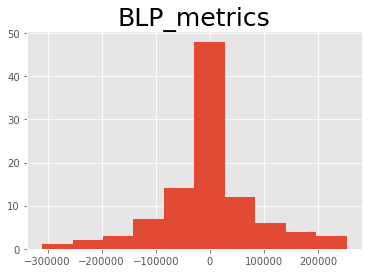

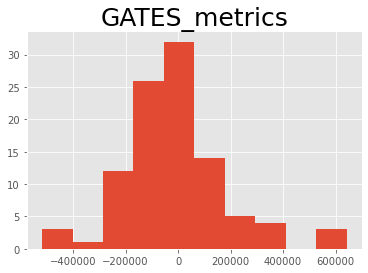

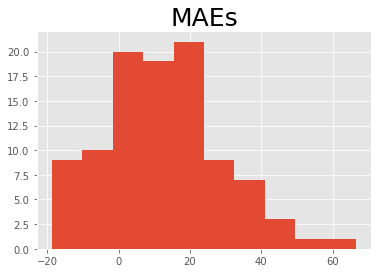

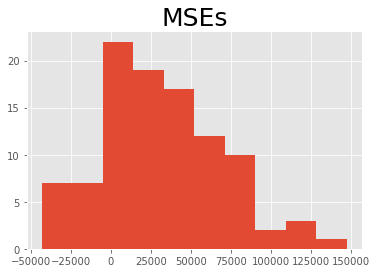

In [61]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = rf0_tune_MSE, model1_A = rf1_tune_Lambda_hat, 
                                                model0_B = rf0_tune_MSE, model1_B = rf1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e+04, tolerance: 8.480e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.122e+04, tolerance: 8.480e+03
  model = cd_fast.enet_coordinate_descent(
  1%|▊                                                                                 | 1/100 [00:00<01:00,  1.63it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 20%|████████████████▏                                                                | 20/100 [00:12<00:48,  1.64it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.281e+04, tolerance: 1.123e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.794e+04, tolerance: 1.123e+04
  model = cd_fast.enet_coordinate_descent(
 21%|█████████████████                                                                | 21/100 [00:12<00:47,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 40%|████████████████████████████████▍                                                | 40/100 [00:24<00:37,  1.61it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.459e+04, tolerance: 1.202e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.967e+04, tolerance: 1.202e+04
  model = cd_fast.enet_coordinate_descent(
 41%|█████████████████████████████████▏                                               | 41/100 [00:25<00:36,  1.62it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:37<00:25,  1.57it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.853e+04, tolerance: 1.067e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.292e+04, tolerance: 1.067e+04
  model = cd_fast.enet_coordinate_descent(
 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:37<00:24,  1.60it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:49<00:12,  1.65it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.569e+04, tolerance: 1.218e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.077e+04, tolerance: 1.218e+04
  model = cd_fast.enet_coordinate_descent(
 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:49<00:11,  1.66it/s]C:\Users\052\anaconda3\lib\site-packages\sklearn\linear_model\

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]

Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.000000,100.000000,100.000000,100.000000
mean,-3861.106320,19140.087340,10.559100,32402.820740
std,23376.003853,163470.804431,15.607381,41308.421754
min,-82368.910000,-332700.660000,-25.410000,-65576.263000
25%,-11639.591000,-84149.179750,0.553750,10274.741750
50%,28.902500,4288.944500,12.160500,33415.114000
75%,8149.319500,102992.877250,19.860500,58554.661750
max,53047.666000,577793.399000,52.097000,131794.865000


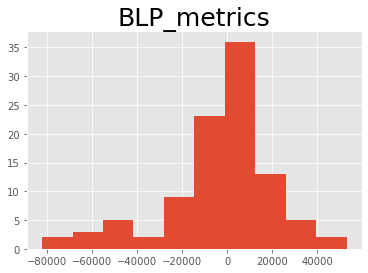

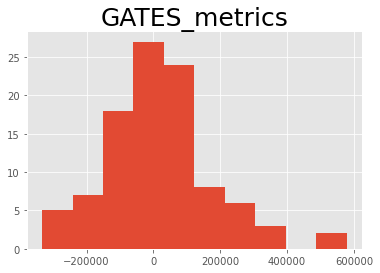

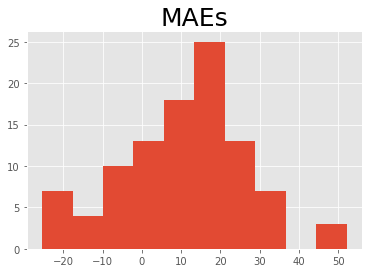

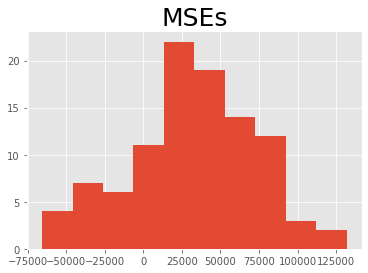

In [62]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = elast0_tune_MSE, model1_A = elast1_tune_Lambda_hat, 
                                                model0_B = elast0_tune_MSE, model1_B = elast1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -157.184934


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -157.184934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004597 seconds.
You can set `force_col_wise=true` to remove the overhead.


  1%|▊                                                                                 | 1/100 [00:00<01:16,  1.30it/s]

[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 89.444018


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -218.899247


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -218.899247
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


  2%|█▋                                                                                | 2/100 [00:01<01:16,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 220.580429


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -104.240704


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -104.240704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_col_wise=true` to remove the overhead.


  3%|██▍                                                                               | 3/100 [00:02<01:15,  1.28it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score -48.322287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -54.882732


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -54.882732
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003535 seconds.
You can set `force_col_wise=true` to remove the overhead.

  4%|███▎                                                                              | 4/100 [00:03<01:14,  1.29it/s]


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 105.934582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003945 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -103.298001


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -103.298001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004628 seconds.
You can set `force_col_wise=true` to remove the overhead.


  5%|████                                                                              | 5/100 [00:03<01:13,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 43.098803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -87.058531


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -87.058531
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004430 seconds.
You can set `force_col_wise=true` to remove the overhead.


  6%|████▉                                                                             | 6/100 [00:04<01:13,  1.28it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 95.440625
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003919 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -91.424412


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -91.424412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004478 seconds.
You can set `force_col_wise=true` to remove the overhead.


  7%|█████▋                                                                            | 7/100 [00:05<01:12,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 125.770568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003893 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -164.915725


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -164.915725
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002737 seconds.
You can set `force_col_wise=true` to remove the overhead.


  8%|██████▌                                                                           | 8/100 [00:06<01:11,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 194.758517


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -121.744454


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -121.744454


  9%|███████▍                                                                          | 9/100 [00:06<01:10,  1.29it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 319.294947


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -178.153351


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -178.153351
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_col_wise=true` to remove the overhead.


 10%|████████                                                                         | 10/100 [00:07<01:10,  1.28it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score -10.420576
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004048 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -233.896420


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -233.896420
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003917 seconds.
You can set `force_col_wise=true` to remove the overhead.

 11%|████████▉                                                                        | 11/100 [00:08<01:08,  1.30it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 388.008439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004323 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -64.526349


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 1264
[LightGBM] [Info] Start training from score -64.526349
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 12%|█████████▋                                                                       | 12/100 [00:09<01:08,  1.29it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 1264
[LightGBM] [Info] Start training from score 69.528627


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -92.658725


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -92.658725
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004498 seconds.
You can set `force_col_wise=true` to remove the overhead.


 13%|██████████▌                                                                      | 13/100 [00:10<01:07,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 23.709218
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004018 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -128.061114


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -128.061114
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_col_wise=true` to remove the overhead.

 14%|███████████▎                                                                     | 14/100 [00:10<01:05,  1.31it/s]


[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 46.270096
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -146.488380


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -146.488380
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 15%|████████████▏                                                                    | 15/100 [00:11<01:04,  1.31it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 9.338317
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -150.991640


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -150.991640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004304 seconds.
You can set `force_col_wise=true` to remove the overhead.


 16%|████████████▉                                                                    | 16/100 [00:12<01:04,  1.29it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 230.395614
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004198 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -133.500783


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 85, number of used features: 1264
[LightGBM] [Info] Start training from score -133.500783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_col_wise=true` to remove the overhead.


 17%|█████████████▊                                                                   | 17/100 [00:13<01:04,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1264
[LightGBM] [Info] Start training from score 168.695502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -206.715603


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -206.715603
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004538 seconds.
You can set `force_col_wise=true` to remove the overhead.


 18%|██████████████▌                                                                  | 18/100 [00:13<01:02,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 258.832988
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004305 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -8.463541


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -8.463541
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002873 seconds.
You can set `force_col_wise=true` to remove the overhead.


 19%|███████████████▍                                                                 | 19/100 [00:14<01:02,  1.30it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 1264
[LightGBM] [Info] Start training from score -121.933927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -196.723286


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -196.723286
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003713 seconds.
You can set `force_col_wise=true` to remove the overhead.


 20%|████████████████▏                                                                | 20/100 [00:15<01:01,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 220.642924
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003941 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -177.865418


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -177.865418
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004448 seconds.
You can set `force_col_wise=true` to remove the overhead.


 21%|█████████████████                                                                | 21/100 [00:16<01:00,  1.30it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 31.268772
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003810 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -173.377611


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -173.377611
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004626 seconds.
You can set `force_col_wise=true` to remove the overhead.


 22%|█████████████████▊                                                               | 22/100 [00:17<01:00,  1.30it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 109.839511


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -87.328161


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -87.328161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004086 seconds.
You can set `force_col_wise=true` to remove the overhead.


 23%|██████████████████▋                                                              | 23/100 [00:17<00:59,  1.30it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -93.235929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004070 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -261.632127


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -261.632127
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003727 seconds.
You can set `force_col_wise=true` to remove the overhead.


 24%|███████████████████▍                                                             | 24/100 [00:18<00:58,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 261.608741
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -108.992977


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -108.992977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.


 25%|████████████████████▎                                                            | 25/100 [00:19<00:58,  1.28it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 98.997079


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -113.685596


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -113.685596
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003198 seconds.
You can set `force_col_wise=true` to remove the overhead.


 26%|█████████████████████                                                            | 26/100 [00:20<00:57,  1.29it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score 93.495822
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -111.330993


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -111.330993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_col_wise=true` to remove the overhead.


 27%|█████████████████████▊                                                           | 27/100 [00:20<00:56,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -118.041968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003802 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -4.886549


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -4.886549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 28%|██████████████████████▋                                                          | 28/100 [00:21<00:55,  1.30it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 107.642931
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -260.560019


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -260.560019
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003795 seconds.
You can set `force_col_wise=true` to remove the overhead.


 29%|███████████████████████▍                                                         | 29/100 [00:22<00:54,  1.30it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 106.242220
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -261.062175


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -261.062175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004431 seconds.
You can set `force_col_wise=true` to remove the overhead.


 30%|████████████████████████▎                                                        | 30/100 [00:23<00:54,  1.28it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 45.221117


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -281.722787


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -281.722787
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004283 seconds.
You can set `force_col_wise=true` to remove the overhead.

 31%|█████████████████████████                                                        | 31/100 [00:23<00:53,  1.29it/s]


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 472.432758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004028 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -237.955158


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -237.955158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_col_wise=true` to remove the overhead.


 32%|█████████████████████████▉                                                       | 32/100 [00:24<00:52,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 163.518962
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004489 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -214.322076


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -214.322076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21488


 33%|██████████████████████████▋                                                      | 33/100 [00:25<00:51,  1.29it/s]

[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 295.823050
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -112.508424


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -112.508424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_col_wise=true` to remove the overhead.


 34%|███████████████████████████▌                                                     | 34/100 [00:26<00:50,  1.30it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score 81.282054
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003972 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -147.831441


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -147.831441
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_col_wise=true` to remove the overhead.


 35%|████████████████████████████▎                                                    | 35/100 [00:27<00:50,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 341.491556


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -104.828106


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -104.828106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004381 seconds.
You can set `force_col_wise=true` to remove the overhead.


 36%|█████████████████████████████▏                                                   | 36/100 [00:27<00:49,  1.29it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 174.097201
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -175.263863


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -175.263863
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004468 seconds.
You can set `force_col_wise=true` to remove the overhead.


 37%|█████████████████████████████▉                                                   | 37/100 [00:28<00:49,  1.28it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 44.737504
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -99.256870


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -99.256870
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_col_wise=true` to remove the overhead.


 38%|██████████████████████████████▊                                                  | 38/100 [00:29<00:48,  1.28it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 85.676334
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003992 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -107.586857


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -107.586857
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004425 seconds.
You can set `force_col_wise=true` to remove the overhead.


 39%|███████████████████████████████▌                                                 | 39/100 [00:30<00:47,  1.27it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 82.107562
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003809 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -96.567403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -96.567403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004752 seconds.
You can set `force_col_wise=true` to remove the overhead.


 40%|████████████████████████████████▍                                                | 40/100 [00:30<00:47,  1.27it/s]

[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 23.854835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004219 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 40.070711


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score 40.070711
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.


 41%|█████████████████████████████████▏                                               | 41/100 [00:31<00:45,  1.28it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score -76.084754
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004156 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -238.480736


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 86, number of used features: 1264
[LightGBM] [Info] Start training from score -238.480736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003535 seconds.
You can set `force_col_wise=true` to remove the overhead.

 42%|██████████████████████████████████                                               | 42/100 [00:32<00:45,  1.29it/s]


[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 49, number of used features: 1264
[LightGBM] [Info] Start training from score 340.390806


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -52.306155


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -52.306155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004532 seconds.
You can set `force_col_wise=true` to remove the overhead.


 43%|██████████████████████████████████▊                                              | 43/100 [00:33<00:44,  1.28it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score -198.374089
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -71.680431


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -71.680431
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004635 seconds.
You can set `force_col_wise=true` to remove the overhead.


 44%|███████████████████████████████████▋                                             | 44/100 [00:34<00:43,  1.29it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 17.689939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004165 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -171.188867


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -171.188867
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004310 seconds.
You can set `force_col_wise=true` to remove the overhead.


 45%|████████████████████████████████████▍                                            | 45/100 [00:34<00:42,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 114.322362
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -105.145111


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 1264
[LightGBM] [Info] Start training from score -105.145111


 46%|█████████████████████████████████████▎                                           | 46/100 [00:35<00:41,  1.30it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 1264
[LightGBM] [Info] Start training from score -31.696169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004228 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -104.402390


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -104.402390
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 47%|██████████████████████████████████████                                           | 47/100 [00:36<00:40,  1.30it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 246.121714
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003709 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 84.874989


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 84.874989
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_col_wise=true` to remove the overhead.


 48%|██████████████████████████████████████▉                                          | 48/100 [00:37<00:40,  1.30it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 54.391407


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -277.480492


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -277.480492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004519 seconds.
You can set `force_col_wise=true` to remove the overhead.


 49%|███████████████████████████████████████▋                                         | 49/100 [00:37<00:39,  1.31it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 242.370106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004003 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -219.242947


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -219.242947
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004187 seconds.
You can set `force_col_wise=true` to remove the overhead.


 50%|████████████████████████████████████████▌                                        | 50/100 [00:38<00:38,  1.30it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 171.934790
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004171 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -52.959704


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -52.959704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004296 seconds.
You can set `force_col_wise=true` to remove the overhead.


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:39<00:37,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score -152.410072
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -107.489531


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -107.489531


 52%|██████████████████████████████████████████                                       | 52/100 [00:40<00:37,  1.28it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 105.356789


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -262.018745


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -262.018745
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004836 seconds.
You can set `force_col_wise=true` to remove the overhead.


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:41<00:37,  1.27it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 196.213332
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -104.565170


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -104.565170
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004619 seconds.
You can set `force_col_wise=true` to remove the overhead.


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:41<00:35,  1.28it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -53.832418
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -58.111091


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -58.111091
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:42<00:34,  1.30it/s]

[LightGBM] [Info] Start training from score 116.782618
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -143.120243


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -143.120243
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004369 seconds.
You can set `force_col_wise=true` to remove the overhead.


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:43<00:33,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 142.692103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003909 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -2.300737


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -2.300737
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_col_wise=true` to remove the overhead.


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:44<00:33,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score -105.465291
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003979 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -203.540698


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -203.540698
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_col_wise=true` to remove the overhead.


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:44<00:32,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 163.099071
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004065 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -254.873681


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -254.873681
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:45<00:31,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 32.103195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004031 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -143.226241


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -143.226241
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003952 seconds.
You can set `force_col_wise=true` to remove the overhead.

 60%|████████████████████████████████████████████████▌                                | 60/100 [00:46<00:30,  1.30it/s]


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 128.478803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003906 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -158.516741


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 1264
[LightGBM] [Info] Start training from score -158.516741
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 1264
[LightGBM] [Info] Start training from score 5.436038


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:47<00:29,  1.30it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -144.573391


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39184
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1264
[LightGBM] [Info] Start training from score -144.573391
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_col_wise=true` to remove the overhead.


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:47<00:29,  1.30it/s]

[LightGBM] [Info] Total Bins 20224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 1264
[LightGBM] [Info] Start training from score 58.678578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003925 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -170.937386


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -170.937386
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004783 seconds.
You can set `force_col_wise=true` to remove the overhead.


 63%|███████████████████████████████████████████████████                              | 63/100 [00:48<00:28,  1.30it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 136.758708
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -191.005211


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -191.005211


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:49<00:28,  1.29it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 225.839213


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -248.322316


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -248.322316
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_col_wise=true` to remove the overhead.


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:50<00:27,  1.28it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score 327.824748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -12.392273


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -12.392273
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004773 seconds.
You can set `force_col_wise=true` to remove the overhead.


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:51<00:26,  1.28it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -281.544317


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -189.548422


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -189.548422
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22752


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:51<00:25,  1.28it/s]

[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 210.595468
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004075 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -193.401791


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -193.401791
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:52<00:24,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -54.986871
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 30336
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 1264
[LightGBM] [Info] Start training from score -197.065631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30336
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 1264
[LightGBM] [Info] Start training from score -197.065631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_col_wise=true` to remove the overhead.


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:53<00:24,  1.29it/s]

[LightGBM] [Info] Total Bins 29072
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 1264
[LightGBM] [Info] Start training from score 113.046705


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 94.836889


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score 94.836889
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:54<00:23,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score -253.921881
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -105.854082


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -105.854082
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004858 seconds.
You can set `force_col_wise=true` to remove the overhead.


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:54<00:22,  1.29it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -112.238172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004263 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -66.012265


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -66.012265
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score 164.456207


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:55<00:21,  1.30it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -44.107947


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -44.107947
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:56<00:20,  1.30it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 43.680335
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -297.158147


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -297.158147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004309 seconds.
You can set `force_col_wise=true` to remove the overhead.


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:57<00:19,  1.30it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 223.728532
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -23.986208


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -23.986208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004212 seconds.
You can set `force_col_wise=true` to remove the overhead.


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:58<00:19,  1.30it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -74.337282
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004160 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -72.632787


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -72.632787
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004323 seconds.
You can set `force_col_wise=true` to remove the overhead.


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:58<00:18,  1.29it/s]C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 160.467939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -127.032636


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -127.032636
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003422 seconds.
You can set `force_col_wise=true` to remove the overhead.

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:59<00:17,  1.29it/s]


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 45.753689
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003908 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -193.178132


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31600
[LightGBM] [Info] Number of data points in the train set: 73, number of used features: 1264
[LightGBM] [Info] Start training from score -193.178132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004863 seconds.
You can set `force_col_wise=true` to remove the overhead.


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:00<00:17,  1.29it/s]

[LightGBM] [Info] Total Bins 27808
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 1264
[LightGBM] [Info] Start training from score 237.908458
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003819 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 5.999396


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score 5.999396


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:01<00:16,  1.28it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score -82.603651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004082 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -193.135183


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -193.135183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004201 seconds.
You can set `force_col_wise=true` to remove the overhead.


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:01<00:15,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 203.248043
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -161.104640


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -161.104640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:02<00:14,  1.29it/s]

[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 125.396023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003851 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -109.109570


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 1264
[LightGBM] [Info] Start training from score -109.109570
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004616 seconds.
You can set `force_col_wise=true` to remove the overhead.


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:03<00:14,  1.28it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 1264
[LightGBM] [Info] Start training from score 14.435561


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -135.767353


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -135.767353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_col_wise=true` to remove the overhead.


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:04<00:13,  1.29it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 105.880096
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004439 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -97.234092


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -97.234092
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_col_wise=true` to remove the overhead.


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:05<00:12,  1.29it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 411.608381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -97.838224


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 87, number of used features: 1264
[LightGBM] [Info] Start training from score -97.838224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004236 seconds.
You can set `force_col_wise=true` to remove the overhead.

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:05<00:11,  1.29it/s]


[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 1264
[LightGBM] [Info] Start training from score -25.410134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003981 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -226.940858


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -226.940858
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24016

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:06<00:10,  1.30it/s]


[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 45.085929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004046 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -129.880138


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 82, number of used features: 1264
[LightGBM] [Info] Start training from score -129.880138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004401 seconds.
You can set `force_col_wise=true` to remove the overhead.


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:07<00:10,  1.30it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 1264
[LightGBM] [Info] Start training from score 1.861079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -292.633274


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 84, number of used features: 1264
[LightGBM] [Info] Start training from score -292.633274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004178 seconds.
You can set `force_col_wise=true` to remove the overhead.


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:08<00:09,  1.31it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 51, number of used features: 1264
[LightGBM] [Info] Start training from score 12.116648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -164.735017


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -164.735017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004558 seconds.
You can set `force_col_wise=true` to remove the overhead.


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:08<00:08,  1.29it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 391.710394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003892 seconds.
You can set `force_col_wise=true` to remove the overhead.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -81.445666


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -81.445666
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:09<00:07,  1.28it/s]


[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 81.886433
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004107 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -210.764918


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34128
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1264
[LightGBM] [Info] Start training from score -210.764918
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004796 seconds.
You can set `force_col_wise=true` to remove the overhead.


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:10<00:07,  1.25it/s]

[LightGBM] [Info] Total Bins 25280
[LightGBM] [Info] Number of data points in the train set: 57, number of used features: 1264
[LightGBM] [Info] Start training from score 103.194839


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -188.179954


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -188.179954
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003706 seconds.
You can set `force_col_wise=true` to remove the overhead.


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:11<00:06,  1.25it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 12.608425


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -191.491992


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 1264
[LightGBM] [Info] Start training from score -191.491992
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_col_wise=true` to remove the overhead.


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:12<00:05,  1.25it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 1264
[LightGBM] [Info] Start training from score 140.885131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004207 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -272.352500


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -272.352500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004407 seconds.
You can set `force_col_wise=true` to remove the overhead.


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:12<00:04,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 414.611698
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -225.411826


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32864
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1264
[LightGBM] [Info] Start training from score -225.411826
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:13<00:03,  1.26it/s]

[LightGBM] [Info] Total Bins 26544
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 1264
[LightGBM] [Info] Start training from score 350.735542
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003940 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -184.411276


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 1264
[LightGBM] [Info] Start training from score -184.411276
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004730 seconds.
You can set `force_col_wise=true` to remove the overhead.


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:14<00:03,  1.26it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 1264
[LightGBM] [Info] Start training from score 163.467390
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004163 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -93.009353


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -93.009353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_col_wise=true` to remove the overhead.


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:15<00:02,  1.26it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score 279.301049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004280 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -86.507787


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36656
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 1264
[LightGBM] [Info] Start training from score -86.507787
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:16<00:01,  1.27it/s]

[LightGBM] [Info] Total Bins 22752
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 1264
[LightGBM] [Info] Start training from score -111.748839
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003930 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -130.239388


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35392
[LightGBM] [Info] Number of data points in the train set: 81, number of used features: 1264
[LightGBM] [Info] Start training from score -130.239388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004371 seconds.
You can set `force_col_wise=true` to remove the overhead.


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:16<00:00,  1.29it/s]

[LightGBM] [Info] Total Bins 24016
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 1264
[LightGBM] [Info] Start training from score 84.167814
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -106.938177


C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\052\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37920
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 1264
[LightGBM] [Info] Start training from score -106.938177
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002943 seconds.
You can set `force_col_wise=true` to remove the overhead.


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]

[LightGBM] [Info] Total Bins 21488
[LightGBM] [Info] Number of data points in the train set: 47, number of used features: 1264
[LightGBM] [Info] Start training from score 130.805070
Metrics table, A model metrics minus B model metrics


,BLP_metrics,GATES_metrics,MAEs,MSEs
count,100.0,100.0,100.0,100.0
mean,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0


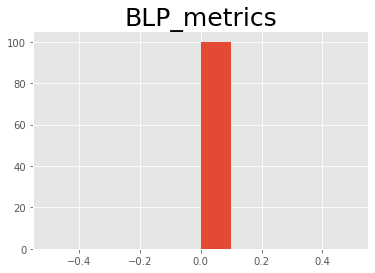

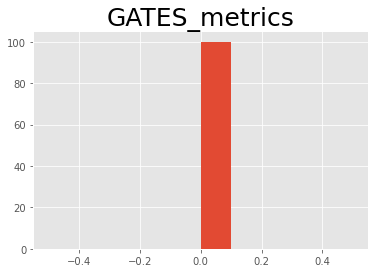

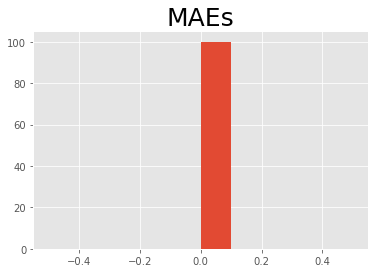

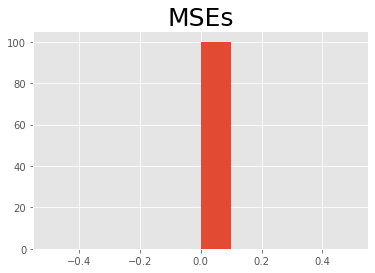

In [63]:
df_metrics =\
        term_paper_main_func_compare_two_models_PAPER_ALGO(model0_A = lgbm0_tune_MSE, model1_A = lgbm1_tune_Lambda_hat, 
                                                model0_B = lgbm0_tune_MSE, model1_B = lgbm1_tune_MSE,
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

In [64]:
lgbm1_tune_MSE.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.02,
 'importance_type': 'split',
 'learning_rate': 0.003,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 2,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': False,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [65]:
lgbm1_tune_Lambda_hat.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.02,
 'importance_type': 'split',
 'learning_rate': 0.003,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 2,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# 4) Baseline models and estimations to compare previous results with 

# Note: even if p > n like in this case, LinearRegression works!!!! I think this is so, because instead of inverting matrices, there is kinda gradient descent/Adam algorithm!!!

## a) Baseline model (linear regression), mechanism like in the paper and in the code above

In [66]:
linreg0 = LinearRegression()
linreg1 = LinearRegression()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]

Metrics table


,BLP_metrics,GATES_metrics,MAEs,MSEs,real_BLP_metrics,beta_2s,real_beta_2s
count,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.00000
mean,28724.922000,208763.921270,873.430030,1.207276e+06,5605.721700,-0.063660,-0.06930
std,41424.548116,113964.868938,50.679251,1.201567e+05,8027.560738,0.410306,0.16798
min,0.726000,20411.257000,749.233000,9.466400e+05,8.663000,-1.149000,-0.51600
25%,2514.148500,121996.990000,840.884000,1.128051e+06,635.352500,-0.316500,-0.18800
50%,12530.611000,204323.504000,867.562000,1.192420e+06,2434.662000,-0.017500,-0.05900
75%,35009.533000,264075.060000,903.099250,1.291161e+06,7315.212000,0.209500,0.05850
max,192048.819000,505142.165000,1013.105000,1.637799e+06,39089.726000,1.062000,0.22800


GATES table


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
G1,231.919,-1374.815,1699.730,-1286.503,-1518.907,-1057.749
G2,47.981,-1319.054,1449.003,-421.795,-530.603,-319.967
G3,10.514,-1417.364,1448.045,127.198,66.888,182.876
G4,-6.653,-1388.506,1347.436,566.867,491.681,641.943
G5,39.244,-1364.750,1464.292,1447.809,1168.654,1730.981


CLAN table group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,231.919,-1374.815,1699.730,-1286.503,-1518.907,-1057.749
x1,1.047,0.394,1.654,1.104,0.547,1.681
x4,9.162,7.578,10.780,8.824,7.160,10.548
x5,35.115,31.550,38.896,35.308,31.786,38.839
x6,-6.371,-9.596,-3.134,-7.654,-11.103,-4.172
...,...,...,...,...,...,...
x1270,-0.965,-2.438,0.540,-1.934,-3.496,-0.414
x1271,0.267,-1.111,1.516,0.165,-1.269,1.609
x1272,2.057,0.363,3.733,1.213,-0.605,3.029
x1273,-0.080,-1.950,1.879,-0.583,-2.452,1.302


CLAN table group 5


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,39.244,-1364.750,1464.292,1447.809,1168.654,1730.981
x1,0.984,0.333,1.613,1.000,0.365,1.638
x4,9.146,7.617,10.718,9.397,7.568,11.254
x5,34.494,30.794,38.297,35.689,31.233,40.173
x6,-6.308,-9.736,-2.979,-5.569,-8.746,-2.371
...,...,...,...,...,...,...
x1270,-1.081,-2.704,0.578,-0.582,-2.004,0.800
x1271,0.956,-0.518,2.443,0.835,-0.528,2.188
x1272,2.074,0.500,3.576,1.452,-0.114,3.017
x1273,0.761,-1.495,2.927,0.466,-1.637,2.628


CLAN table group 5 minus group 1


,est,est_[0.025,0.975]_est,real,real_[0.025,0.975]_real
GATES,-209.229,-2280.133,1914.980,2730.106,2371.250,3101.504
x1,-0.070,-0.970,0.828,-0.081,-0.936,0.763
x4,-0.029,-2.228,2.218,0.541,-1.917,3.075
x5,-0.670,-5.942,4.556,0.425,-5.316,6.193
x6,0.022,-4.619,4.692,2.158,-2.565,6.864
...,...,...,...,...,...,...
x1270,-0.043,-2.310,2.181,1.332,-0.788,3.411
x1271,0.694,-1.267,2.716,0.655,-1.341,2.574
x1272,0.089,-2.193,2.432,0.270,-2.169,2.646
x1273,0.672,-2.196,3.569,1.064,-1.864,3.891


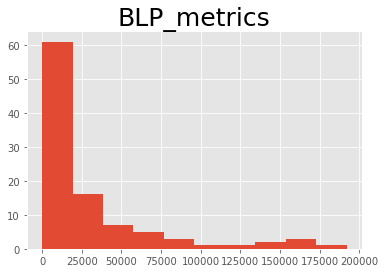

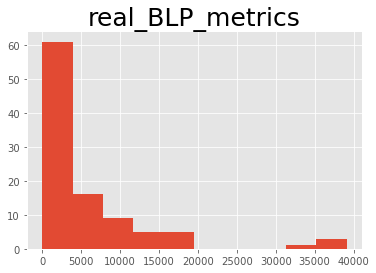

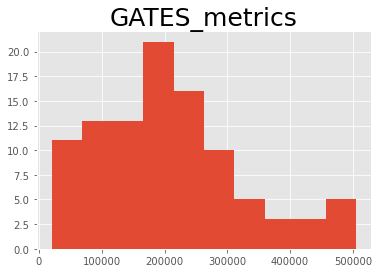

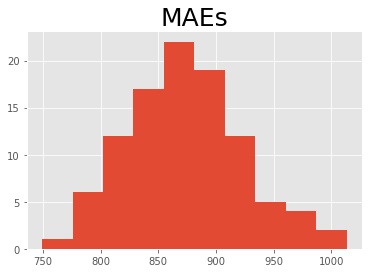

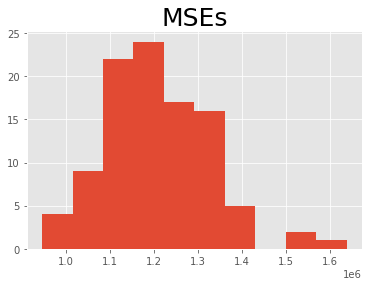

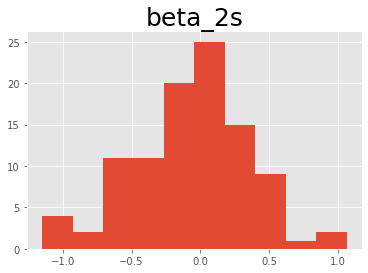

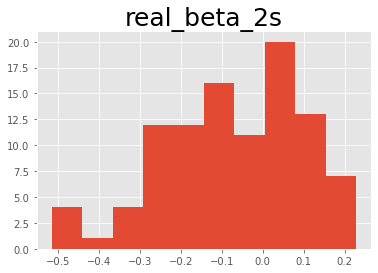

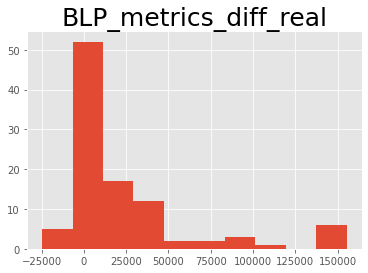

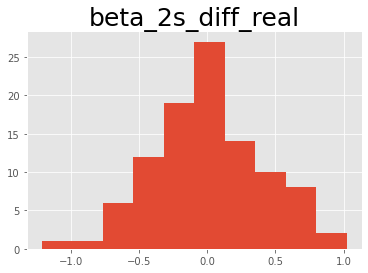

In [67]:
df_metrics, df_GATES, df_CLAN_group1, df_CLAN_group5, df_CLAN_group5_minus_group1 =\
            term_paper_main_func_PAPER_ALGO(model0 = linreg0, model1 = linreg1, 
                                 df = df.copy(), n_splits = 100, show_BLP = False, extended = True)

## b) Naive strategy: just coef to D of simple regression with OOF metrics!!!

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.27it/s]

Metrics table


,MAEs,MSEs
count,100.000000,1.000000e+02
mean,769.650220,9.439984e+05
std,35.288176,7.991827e+04
min,699.606000,7.583242e+05
25%,745.440750,8.922876e+05
50%,766.442500,9.484063e+05
75%,794.614500,1.003654e+06
max,858.695000,1.111456e+06


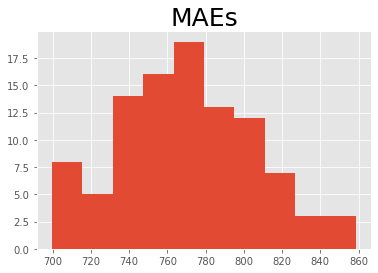

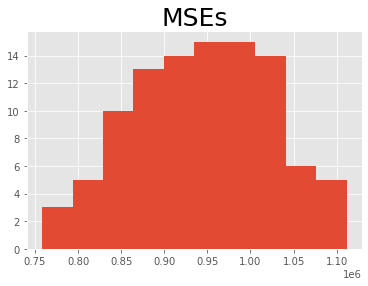

In [68]:
df_metrics =\
        term_paper_main_func_easy_baseline(df = df.copy(), n_splits = 100, extended = True)